# Parameterized Models 

We will create polynomial models for data tables so that we can produce values at any given input point.

In [242]:
##############################################################
### Set up libraries and global variables
##############################################################
 
import pandas as pd
pd.options.mode.chained_assignment = None    # no warning message and no exception is raised

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy.stats import linregress
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar


from statsmodels.nonparametric.smoothers_lowess import lowess     # A function for interpolating a plot using the locally weighed scatterplot smoothing method. Returns smoothed x,y points
from scipy.interpolate import CubicSpline                         # A function for interpolating a plot using the cubic spline method. Returns an interpolation function.
from scipy.interpolate import interp1d                            # A function for interpolating a plot using the connect-the-dots method. Returns an interpolation function.
from scipy.interpolate import make_smoothing_spline               # A function for interpolating a plot using a Bspline algorithm. Returns an interpolation function.

from matplotlib.patches import PathPatch
from matplotlib.path import Path

import interpolators  # A library of interpolation functions

#github_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_30/data/"
github_location = "./data/"
#github_location_styles = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
github_location_styles = "./styles/"
github_location_LFER_tables = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"

molwtH2SO4 = 98.079
molwtH2O = 18.015
densityH2SO4 = 1.83
densityH2O = 1.00

aH2O_Data_File_Name = "01_Giauque_Table9_activityH2OinH2SO4.csv"

## Converting Molal to %mass

The code below will convert molality to %mass and moles/L

In [243]:
##############################################################
### Import the data and perform calculations
##############################################################

Data_File_Name = "03_H2SO4_PercentWt_to_MolarConc_CRC.csv"

Filename = github_location + Data_File_Name

df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

### Rename columns to make them easier to use
df = df.rename(columns={"%H2SO4": "PercentWt",
                        "m(mol/Kg)": "Molal",
                        "mol/L": "Molar",
                        "Density": "Density"})

display(df.head(3))

### Convert Molal to PercentWt
### PercentWt = (molality * molwtH2SO4) / (molality * molwtH2SO4 + 1000) * 100
df["PercentWt_Calc"] = (df["Molal"] * molwtH2SO4) / (df["Molal"] * molwtH2SO4 + 1000) * 100 

### Convert Molal to Molar
### Molar = Molal * densityH2SO4 / (1 + (molality * (molwtH2SO4 - molwtH2O) / 1000))                
volume = (df["Molal"] * molwtH2SO4 + 1000) / df["Density"] /1000
df["Molar_Calc"] = df["Molal"]/volume


### calculate difference between calculated and table values
df["PercentWt_Diff"] = (df["PercentWt_Calc"] - df["PercentWt"])/df["PercentWt"] * 100
df["Molar_Diff"] = (df["Molar_Calc"] - df["Molar"])/df["Molar"] * 100

display(df)


,PercentWt,Molal,Molar,Density
0,0.0,0.000,0.000,0.99821
1,0.5,0.051,0.051,1.00160
2,1.0,0.103,0.102,1.00490


,PercentWt,Molal,Molar,Density,PercentWt_Calc,Molar_Calc,PercentWt_Diff,Molar_Diff
0,0.0,0.000,0.000,0.99821,0.000000,0.000000,NaN,NaN
1,0.5,0.051,0.051,1.00160,0.497713,0.050827,-0.457335,-0.338510
2,1.0,0.103,0.102,1.00490,1.000110,0.102470,0.011045,0.460332
3,2.0,0.208,0.206,1.01160,1.999257,0.206206,-0.037126,0.100052
4,3.0,0.315,0.311,1.01830,2.996900,0.311152,-0.103346,0.048717
...,...,...,...,...,...,...,...,...
57,92.0,117.251,17.109,1.82400,91.999911,17.109456,-0.000097,0.002668
58,94.0,159.734,17.550,1.83120,93.999958,17.550416,-0.000044,0.002370
59,96.0,244.698,17.966,1.83550,95.999958,17.965917,-0.000044,-0.000459
60,98.0,499.592,18.346,1.83610,97.999979,18.346207,-0.000021,0.001127


Differential between reported molarity and value calculated from reported molality and density
Using density from CRC table at 20C


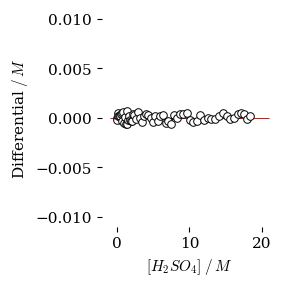

In [244]:
#x = df["PercentWt"]
x = df["Molar"]
y_w_diff = df["PercentWt_Calc"]-df["PercentWt"]
y_M_diff = df["Molar_Calc"]-df["Molar"]

#y = y_w_diff
#y = df["PercentWt_Diff"]
#y = df["Molar_Diff"]
y = y_M_diff

###################################################
### MAKE PLOT
###################################################

###################################################
### Create figure for plot
###################################################

style = "tufte.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))  
#ax2 = ax.twinx()

###################################################
### Set up labels
###################################################

x_label = r"$[H_2SO_4]\;/\,M$" 
y_label = r"Differential$\;/\,M$" 


###################################################
### RATE vs ACIDITY Plot
###################################################

# Set up axes for main plot
ax.set(ylabel=y_label, xlabel=x_label,
#        xlim=[-0.011,0.011],
        ylim=[-0.011,0.011]
        )
# Data points for kobs vs Acidity

ax.scatter(x, y, 
          marker = "o", s = 30, 
          color = "white", edgecolors = "black", linewidths=0.7, 
          zorder = 2)
#ax.scatter(x, y,           # White circle behind each data point 
#          marker = "o", s = 90, 
#          color = "white", 
#          zorder = 1)
ax.plot(x, y,  
          color = "black", linewidth=0.7, 
          zorder = 1)
ax.hlines(0, -1,21, color="red", linewidth=0.7, zorder = 0)   # horizontal line at y=0
#ax.set(xticks = [0,25,50],
#       yticks = [0,25,50]
#        )
# 1:1 line
print("Differential between reported molarity and value calculated from reported molality and density")
print("Using density from CRC table at 20C")
plt.savefig("plots/plot_A1.pdf")
plt.show()

###################################################
###################################################
### Differential Plot
###################################################




## At 25degC

The data above from the CRC handobbok was a data tabkle for 20degC.  There is a second table availabe in the web edition of the hanbook that gives the data at several different tempertures including 20 and 25 degC. The data below is from "Perry's Chemical Engineers' Handbook" 7th ed., section 2-107. It is the same data table as in the CRC but reports data at every degree rather than every second degree. It is just the output of a parameterized model that I have no information about.

### Refs

A very recent paper that is much too complicated

Genetic Algorithm Workflow for Parameterization of a Water Model Using the Vashishta Force Field
Anthony Val C. Camposano, Even Marius Nordhagen, Henrik Andersen Sveinsson, and Anders Malthe-So̷renssen
The Journal of Physical Chemistry B 2025 129 (4), 1331-1342
DOI: 10.1021/acs.jpcb.4c06389

A polynomial model for pure water density (and also salt water)

Baddour, R. E. (2023). Thermohaline equation of state for pure water, seawater and brine. Journal of Hydraulic Research, 61(2), 211–219. https://doi.org/10.1080/00221686.2023.2180444

densitywater(Temp degC)(kg/m^3) = (9.99864928×10^2) + (5.72357369×10^−2)⁢ T + (−7.96007024×10^−3⁢)T^2 + (5.32777547×10^−5)⁢T^3 + (−2.60322680×10^−7⁢)T^4 + (5.11178237×10−10)⁢T^5

Polynomial fits for sulfuric acid mixtures at given temp. Up to 40%H2SO4 only

Review and Analysis of Thermophysical Properties of a Sulfuric Acid–Water Electrolyte
Laura Oca, Jose Miguel Campillo-Robles, and M. Mounir Bou-Ali
Journal of Chemical & Engineering Data 2018 63 (9), 3572-3583
DOI: 10.1021/acs.jced.8b00466
GET ref 40, 41, 47,48,49 etc...

Data Set from 

Tables of physical and chemical constants and some mathematical functions / originally compiled by G.W.C. Kaye and T.H. Laby ; now prepared under the direction of an editorial committee.
London ; New York : Longman, 1986. 15th ed.
Reference section of library	QC61.K3 1986 REF

A four parameter fit
Surface Tensions and Densities of Sulfuric Acid + Dimethylamine + Water Solutions
Antti-P. Hyvärinen, Heikki Lihavainen, Kaisa Hautio, Tomi Raatikainen, Yrjö Viisanen, and Ari Laaksonen
Journal of Chemical & Engineering Data 2004 49 (4), 917-922
DOI: 10.1021/je034225b

Crazy Fits
Densities and Apparent Molar Volumes of Atmospherically Important Electrolyte Solutions. 1. The Solutes H2SO4, HNO3, HCl, Na2SO4, NaNO3, NaCl, (NH4)2SO4, NH4NO3, and NH4Cl from 0 to 50 °C, Including Extrapolations to Very Low Temperature and to the Pure Liquid State, and NaHSO4, NaOH, and NH3 at 25 °C
S. L. Clegg and A. S. Wexler
The Journal of Physical Chemistry A 2011 115 (15), 3393-3460
DOI: 10.1021/jp108992a
see refs 2, 184, 117, 109

In [245]:
Data_File_Name = "03_H2SO4_PercentWt_to_Density_Temp_Perry.csv"

Filename = github_location + Data_File_Name

df2 = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

### Rename columns to make them easier to use
df2 = df2.rename(columns={"%H2SO4": "PercentWt",
                        })

display(df2.head(3))

display(df.head(5))

### Convert Molal to PercentWt
### PercentWt = (molality * molwtH2SO4) / (molality * molwtH2SO4 + 1000) * 100
df["PercentWt_Calc"] = (df["Molal"] * molwtH2SO4) / (df["Molal"] * molwtH2SO4 + 1000) * 100 

### Convert Molal to Molar
### Molar = Molal * densityH2SO4 / (1 + (molality * (molwtH2SO4 - molwtH2O) / 1000))      
#density = df2["20C"]          
#density = df["Density"]          
density = np.interp(df["PercentWt"], df2["PercentWt"], df2["20C"])

volume = (df["Molal"] * molwtH2SO4 + 1000) / density /1000
df["Molar_Calc"] = df["Molal"]/volume

### calculate difference between calculated and table values
df["PercentWt_Diff"] = (df["PercentWt_Calc"] - df["PercentWt"])/df["PercentWt"] * 100
df["Molar_Diff"] = (df["Molar_Calc"] - df["Molar"])/df["Molar"] * 100

display(df)


,PercentWt,0C,10C,15C,20C,25C,30C,40C,50C,60C,80C,100C
0,0,NaN,0.9997,0.9991,0.99821,0.99705,0.99565,0.99222,0.98804,0.9832,0.97179,NaN
1,1,1.0074,1.0068,1.0060,1.00510,1.00380,1.00220,0.99860,0.99440,0.9895,0.97790,0.9645
2,2,1.0147,1.0138,1.0129,1.01180,1.01040,1.00870,1.00500,1.00060,0.9956,0.98390,0.9705


,PercentWt,Molal,Molar,Density,PercentWt_Calc,Molar_Calc,PercentWt_Diff,Molar_Diff
0,0.0,0.000,0.000,0.99821,0.000000,0.000000,NaN,NaN
1,0.5,0.051,0.051,1.00160,0.497713,0.050827,-0.457335,-0.338510
2,1.0,0.103,0.102,1.00490,1.000110,0.102470,0.011045,0.460332
3,2.0,0.208,0.206,1.01160,1.999257,0.206206,-0.037126,0.100052
4,3.0,0.315,0.311,1.01830,2.996900,0.311152,-0.103346,0.048717


,PercentWt,Molal,Molar,Density,PercentWt_Calc,Molar_Calc,PercentWt_Diff,Molar_Diff
0,0.0,0.000,0.000,0.99821,0.000000,0.000000,NaN,NaN
1,0.5,0.051,0.051,1.00160,0.497713,0.050830,-0.457335,-0.333037
2,1.0,0.103,0.102,1.00490,1.000110,0.102490,0.011045,0.480326
3,2.0,0.208,0.206,1.01160,1.999257,0.206247,-0.037126,0.119842
4,3.0,0.315,0.311,1.01830,2.996900,0.311182,-0.103346,0.058542
...,...,...,...,...,...,...,...,...
57,92.0,117.251,17.109,1.82400,91.999911,17.109456,-0.000097,0.002668
58,94.0,159.734,17.550,1.83120,93.999958,17.550416,-0.000044,0.002370
59,96.0,244.698,17.966,1.83550,95.999958,17.965917,-0.000044,-0.000459
60,98.0,499.592,18.346,1.83610,97.999979,18.346207,-0.000021,0.001127


## 

Differential between reported molarity and value calculated from reported molality and density
Using density interpolated from Perry table at 20C


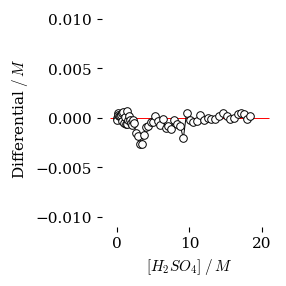

In [246]:
x = df["PercentWt"]
x = df["Molar"]

y_w_diff = df["PercentWt_Calc"]-df["PercentWt"]
y_M_diff = df["Molar_Calc"]-df["Molar"]

y = y_w_diff
#y = df["PercentWt_Diff"]
y = df["Molar_Diff"]
y = y_M_diff
####################################################
### MAKE PLOT
###################################################

###################################################
### Create figure for plot
###################################################

style = "tufte.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))  
#ax2 = ax.twinx()

###################################################
### Set up labels
###################################################

x_label = r"$[H_2SO_4]\;/\,M$" 
y_label = r"Differential$\;/\,M$" 


###################################################
### RATE vs ACIDITY Plot
###################################################

# Set up axes for main plot
ax.set(ylabel=y_label, xlabel=x_label,
#        xlim=[-2,50],
        ylim=[-0.011,0.011]
        )
# Data points for kobs vs Acidity

ax.scatter(x, y, 
          marker = "o", s = 30, 
          color = "white", edgecolors = "black", linewidths=0.7, 
          zorder = 2)
#ax.scatter(x, y,           # White circle behind each data point 
#          marker = "o", s = 90, 
#          color = "white", 
#          zorder = 1)
ax.plot(x, y,  
          color = "black", linewidth=0.7, 
          zorder = 1)
ax.hlines(0, -1,21, color="red", linewidth=0.7, zorder = 0)   # horizontal line at y=0
#ax.set(xticks = [0,25,50],
#       yticks = [0,25,50]
#        )
# 1:1 line
print("Differential between reported molarity and value calculated from reported molality and density")
print("Using density interpolated from Perry table at 20C")
plt.savefig("plots/plot_A2.pdf")
plt.show()

###################################################
###################################################
### Differential Plot
###################################################




Differential between reported %H2SO4 and value calculated from reported molality


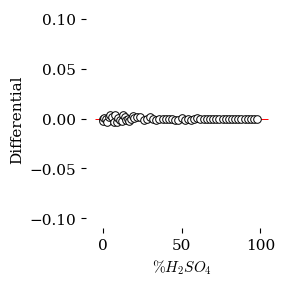

In [247]:
x = df["PercentWt"]
y_w_diff = df["PercentWt_Calc"]-df["PercentWt"]
y_M_diff = df["Molar_Calc"]-df["Molar"]

y = y_w_diff
#y = df["PercentWt_Diff"]
#y = df["Molar_Diff"]
####################################################
### MAKE PLOT
###################################################

###################################################
### Create figure for plot
###################################################

style = "tufte.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))  
#ax2 = ax.twinx()

###################################################
### Set up labels
###################################################

x_label = r"$\%H_2SO_4$" 
y_label = r"Differential" 


###################################################
### RATE vs ACIDITY Plot
###################################################

# Set up axes for main plot
ax.set(ylabel=y_label, xlabel=x_label,
#        xlim=[-2,50],
        ylim=[-0.11,0.11]
        )
# Data points for kobs vs Acidity

ax.scatter(x, y, 
          marker = "o", s = 30, 
          color = "white", edgecolors = "black", linewidths=0.7, 
          zorder = 2)
#ax.scatter(x, y,           # White circle behind each data point 
#          marker = "o", s = 90, 
#          color = "white", 
#          zorder = 1)
ax.plot(x, y,  
          color = "black", linewidth=0.7, 
          zorder = 1)
ax.hlines(0, -5,105, color="red", linewidth=0.7, zorder = 0)   # horizontal line at y=0
#ax.set(xticks = [0,25,50],
#       yticks = [0,25,50]
#        )
# 1:1 line
print("Differential between reported %H2SO4 and value calculated from reported molality")
plt.savefig("plots/plot_A3.pdf")
plt.show()

###################################################
###################################################
### Differential Plot
###################################################




## Parameterized Model for Density

Below I will make a parameterized model for density vs %mass.

First I will plot my data sets."


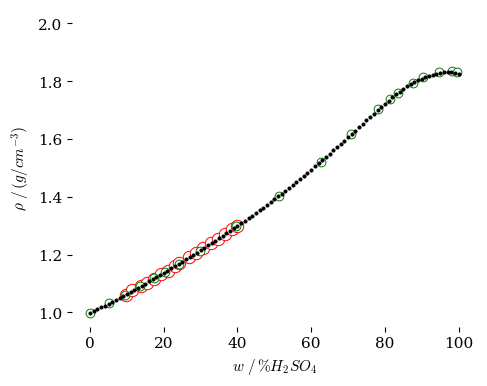

In [248]:
###################################################
### Create figure for plot
###################################################

style = "tufte.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  
#ax2 = ax.twinx()

###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$\rho\ / \,(g/cm^{-3})$" 


###################################################
### RATE vs ACIDITY Plot
###################################################

# Set up axes for main plot
ax.set(ylabel=y_label, xlabel=x_label,
        xlim=[-5,105],
        ylim=[0.95,2.05]
        )
# Data points for kobs vs Acidity

###################################################
### Get and plot Perry data
###################################################

Data_File_Name = "03_H2SO4_PercentWt_to_Density_Temp_Perry.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

x = df["%H2SO4"]
y = df["25C"]

#ax.plot(x, y,  
#          color = "black", linewidth=0.7, 
#          zorder = 1)
ax.scatter(x, y, 
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 3)


###################################################
### Get and plot Rhodes data
###################################################

Data_File_Name = "03_H2SO4_PercentWt_to_Density_Temp_Rhodes.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

x = df["%H2SO4"]
y = df["25C"]

#ax.plot(x, y,  
#          color = "black", linewidth=0.7, 
#          zorder = 1)

ax.scatter(x, y, 
          marker = "o", s = 40, 
          color = "white", edgecolors = "green", linewidths=0.7, 
          zorder = 2)
###################################################
### Get and plot Oca data
###################################################

Data_File_Name = "03_H2SO4_PercentWt_to_Density_Temp_Oca.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

x = df["%H2SO4"]*100
y = df["298.15K"]/1000

ax.scatter(x, y, 
          marker = "o", s = 80, 
          color = "white", edgecolors = "red", linewidths=0.7, 
          zorder = 1)

#ax.plot(x, y,  
#          color = "red", linewidth=2, 
#          zorder = 1)

plt.savefig("plots/plot_B1.pdf")
plt.show()


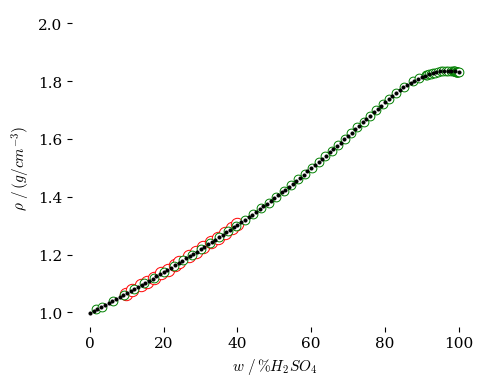

In [249]:
###################################################
### Create figure for plot
###################################################

style = "tufte.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  
#ax2 = ax.twinx()

###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$\rho\ / \,(g/cm^{-3})$" 


###################################################
### RATE vs ACIDITY Plot
###################################################

# Set up axes for main plot
ax.set(ylabel=y_label, xlabel=x_label,
        xlim=[-5,105],
        ylim=[0.95,2.05]
        )
# Data points for kobs vs Acidity

###################################################
### Get and plot Perry data
###################################################

Data_File_Name = "03_H2SO4_PercentWt_to_Density_Temp_Perry.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

x = df["%H2SO4"]
y = df["20C"]

#ax.plot(x, y,  
#          color = "black", linewidth=0.7, 
#          zorder = 1)
ax.scatter(x, y, 
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 3)


###################################################
### Get and plot Rhodes data
###################################################

Data_File_Name = "03_H2SO4_PercentWt_to_Density_Temp_Kaye.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

x = df["%H2SO4"]
y = df["20C"]

#ax.plot(x, y,  
#          color = "black", linewidth=0.7, 
#          zorder = 1)

ax.scatter(x, y, 
          marker = "o", s = 40, 
          color = "white", edgecolors = "green", linewidths=0.7, 
          zorder = 2)
###################################################
### Get and plot Oca data
###################################################

Data_File_Name = "03_H2SO4_PercentWt_to_Density_Temp_Oca.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

x = df["%H2SO4"]*100
y = df["293.15K"]/1000

ax.scatter(x, y, 
          marker = "o", s = 80, 
          color = "white", edgecolors = "red", linewidths=0.7, 
          zorder = 1)

#ax.plot(x, y,  
#          color = "red", linewidth=2, 
#          zorder = 1)
plt.savefig("plots/plot_B2.pdf")
plt.show()


## make the Polynomial Model and Fit

[-2.16110754e-08  3.61273738e-06 -1.54569891e-04  9.46862566e-03
  9.86506794e-01]


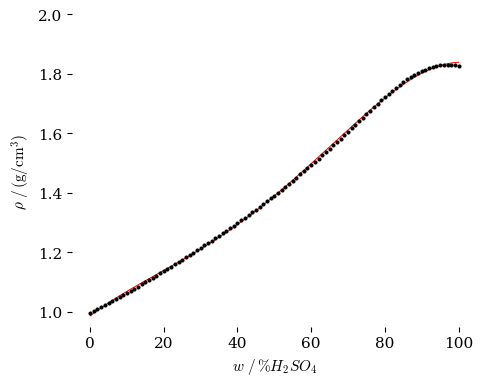

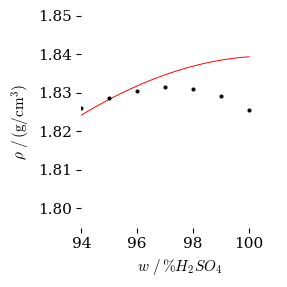

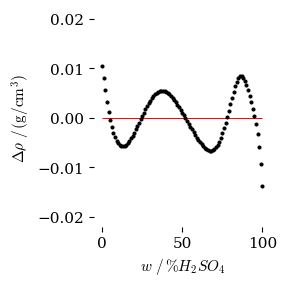

In [250]:
deg = 4
seed = 99

###################################################
### Create figure for plot
###################################################

style = "tufte.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  
#ax2 = ax.twinx()

###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$\rho\ / \,(\text{g/cm}^{3})$" 


###################################################
### RATE vs ACIDITY Plot
###################################################

# Set up axes for main plot
ax.set(ylabel=y_label, xlabel=x_label,
        xlim=[-5,105],
        ylim=[0.95,2]
        )
# Data points for kobs vs Acidity

###################################################
### Get a Perry data
###################################################

Data_File_Name = "03_H2SO4_PercentWt_to_Density_Temp_Perry.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 


###################################################
### remove 25 data points from dataframe at random. Keep both sets.
###################################################

validate_df = df.sample(n=10, random_state=seed).sort_values(by="%H2SO4")
train_df = df.drop(validate_df.index)   

if 0:
    display(validate_df)
    display(train_df)

###################################################
### Fit a Polynomial Model to the training data
###################################################

#x = train_df["%H2SO4"]
#y = train_df["25C"]

x = df["%H2SO4"]
y = df["25C"]

p = np.polyfit(x, y, deg, rcond=None, full=False, w=None, cov=False)
print(p)
###################################################
### plot results of polynomial for x
################################################### 

x1 = np.linspace(0,100,500)
y1 = np.polyval(p, x1)

ax.scatter(x, y, 
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 2)
ax.plot(x1, y1,  
          color = "red", linewidth=0.7, 
          zorder = 1)
plt.savefig("plots/plot_B3.pdf")
plt.show()



###################################################
###################################################
###################################################
###################################################

###################################################
### Create figure for plot
###################################################

style = "tufte.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))  
#ax2 = ax.twinx()

###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$\rho\ / \,(\text{g/cm}^{3})$" 


###################################################
### RATE vs ACIDITY Plot
###################################################

# Set up axes for main plot
ax.set(ylabel=y_label, xlabel=x_label,
        xlim=[94,101],
        ylim=[1.795,1.85]
        )

ax.scatter(x, y, 
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 2)
ax.plot(x1, y1,  
          color = "red", linewidth=0.7, 
          zorder = 1)
plt.savefig("plots/plot_B3A.pdf")
plt.show()


###################################################
###################################################
###################################################
###################################################


###################################################
### Create figure for plot
###################################################

style = "tufte.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))  
#ax2 = ax.twinx()

###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$\Delta \rho\ / \,(\text{g/cm}^{3})$" 


###################################################
### RATE vs ACIDITY Plot
###################################################

# Set up axes for main plot
ax.set(ylabel=y_label, xlabel=x_label,
        xlim=[-5,105],
        ylim=[-0.022,0.022]
        )
# Data points for kobs vs Acidit
###################################################
### calculate difference
###################################################
x_diff = validate_df["%H2SO4"]
y_diff = validate_df["25C"] - np.polyval(p, validate_df["%H2SO4"])

x_diff = x
y_diff = y - np.polyval(p, x_diff)


ax.scatter(x_diff, y_diff, 
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 2)
#ax.plot(x_diff, y_diff,  
#          color = "black", linewidth=0.7, 
#          zorder = 1)
ax.hlines(0, 0,100, color="red", linewidth=0.7, zorder = 0)   # horizontal line at y=0

plt.savefig("plots/plot_B4.pdf")
plt.show()



[-2.27374401e-08  3.58002513e-06 -1.30169768e-04  8.29495325e-03
  9.94729453e-01]
0      0.542021
1      1.611799
2      3.181734
3      4.205899
4     12.688942
5     22.995908
6     34.999381
7     43.749331
8     54.443770
9     64.473061
10    74.564702
11    83.403879
Name: X H2SO4, dtype: float64


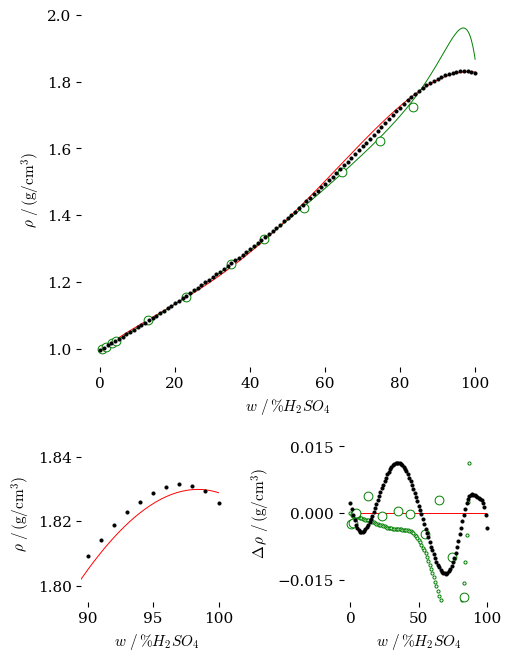

In [251]:
deg = 4
seed = 99

###################################################
### Create figure for plot with insets
###################################################


gs_kw = dict(width_ratios=[1, 1], height_ratios=[2, 1])
fig, axd = plt.subplot_mosaic([['top', 'top'],
                               ['left', 'right']],
                              gridspec_kw=gs_kw, figsize=(5, 6.5),
                              layout="constrained")


style = "tufte.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)


###################################################
### Get a Perry data
###################################################

Data_File_Name = "03_H2SO4_PercentWt_to_Density_Temp_Perry.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

Data_File_Name = "03_H2SO4_PercentWt_to_Density_Temp_Hyvarinen.csv"
Filename = github_location + Data_File_Name
df2 = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

x_hyv = df2["X H2SO4"]
x_hyv_w = (x_hyv*molwtH2SO4)/(x_hyv*molwtH2SO4+(1-x_hyv)*molwtH2O)*100
y_hyv = df2["25C"]/1000

###################################################
### remove 25 data points from dataframe at random. Keep both sets.
###################################################

validate_df = df.sample(n=10, random_state=seed).sort_values(by="%H2SO4")
train_df = df.drop(validate_df.index)   

if 0:
    display(validate_df)
    display(train_df)

###################################################
### Fit a Polynomial Model to the training data
###################################################

#x = train_df["%H2SO4"]
#y = train_df["25C"]

x = df["%H2SO4"]
y = df["25C"]

# set weights for polynomial fit

weights = [1]*len(x)                         # create list of ones same length as x
#weights[-10:] = [10]*10                     # relace last 10 entries in list with 10
weights[-10:] = [1,2,3,4,5,6,7,8,9,10]       # replace last 10 entries in list
#weights[0:10] = [10]*10                     # relace first 10 entries in list with 10
weights[0:10] = [10,9,8,7,6,5,4,3,2,1]       # replace first 10 entries in list
#print(weights)
#weights = None                               # erase weights to do unweighted fit

# fit polynomial with weights
p = np.polyfit(x, y, deg, rcond=None, full=False, w=weights, cov=False)
print(p)

x1 = np.linspace(0,100,500)                  # x values for polynomial line
y1 = np.polyval(p, x1)

p1 = [-4410, 9090, -7230,  3420, 997.05]

x1_mf = (x1/molwtH2SO4)/((x1/molwtH2SO4)+(100-x1)/molwtH2O) # convert line w to mole fraction
x_mf = (x/molwtH2SO4)/((x/molwtH2SO4)+(100-x)/molwtH2O)     # convert Perry w to mole fraction

y2 = np.polyval(p1, x1_mf)/1000                # y values for polynomial line with fixed coefficients 
y_mf = np.polyval(p1, x_mf)/1000               # y values for Perry w with fixed coefficients 
y_hyv_mf = np.polyval(p1, x_hyv)/1000          # y values for Hyvarinen w with fixed coefficients

###################################################
###################################################
###################################################
###################################################


###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$\rho\ / \,(\text{g/cm}^{3})$" 


###################################################
### Polynomial Fit Plot
###################################################

# Set up axes for main plot
axd["top"].set(ylabel=y_label, xlabel=x_label,
#        xlim=[-5,105],
#        ylim=[0.89,2]
        )
# Data points for kobs vs Acidity

axd["top"].scatter(x, y, 
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 2)
axd["top"].plot(x1, y1,  
          color = "red", linewidth=0.7, 
          zorder = 1)
axd["top"].plot(x1, y2,  
          color = "green", linewidth=0.7, 
          zorder = 1)

axd["top"].scatter(x_hyv_w, y_hyv, 
          marker = "o", s = 40, 
          color = "white", edgecolors = "green", linewidths=0.7, 
          zorder = 1)



###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$\rho\ / \,(\text{g/cm}^{3})$" 


###################################################
### Plot results of polynomial fit - inset
###################################################


# Set up axes for main plot
axd["left"].set(ylabel=y_label, xlabel=x_label,
        xlim=[89.5,101],
        ylim=[1.795,1.85]
        )

axd["left"].scatter(x, y, 
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 2)
axd["left"].plot(x1, y1,  
          color = "red", linewidth=0.7, 
          zorder = 1)
#axd["left"].plot(x1, y2,  
#          color = "green", linewidth=0.7, 
#          zorder = 1)


###################################################
###################################################
###################################################
###################################################




###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$\Delta\, \rho\ / \,(\text{g/cm}^{3})$" 


###################################################
### RATE vs ACIDITY Plot
###################################################

# Set up axes for main plot
axd["right"].set(ylabel=y_label, xlabel=x_label,
        xlim=[-5,105],
        ylim=[-0.02,0.02],
        yticks = [-0.015,0,0.015]       
        )
# Data points for kobs vs Acidit
###################################################
### calculate difference
###################################################
# x_diff = validate_df["%H2SO4"]
# y_diff = validate_df["25C"] - np.polyval(p, validate_df["%H2SO4"])

x_diff = x
y_diff = y - np.polyval(p, x_diff)

axd["right"].scatter(x_diff, y_diff, 
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 5)

x_diff = x
y_diff = y_mf - y

axd["right"].scatter(x_diff, y_diff, 
          marker = "o", s = 5, 
          color = "white", edgecolors = "green", linewidths=0.7, 
          zorder = 2)

x_diff = x_hyv_w
y_diff = y_hyv - y_hyv_mf

axd["right"].scatter(x_diff, y_diff, 
          marker = "o", s = 40, 
          color = "white", edgecolors = "green", linewidths=0.7, 
          zorder = 2)

#axd["right"].plot(x_diff, y_diff,  
#          color = "black", linewidth=0.7, 
#          zorder = 1)
axd["right"].hlines(0, 0,100, color="red", linewidth=0.7, zorder = 0)   # horizontal line at y=0

print(x_hyv_w)
plt.savefig("plots/plot_B5.pdf")
plt.show()


[-1.66034812e-12  1.74391677e-10  3.16815068e-09 -6.35831565e-07
  4.29036112e-05  6.34761619e-03  9.97297592e-01]


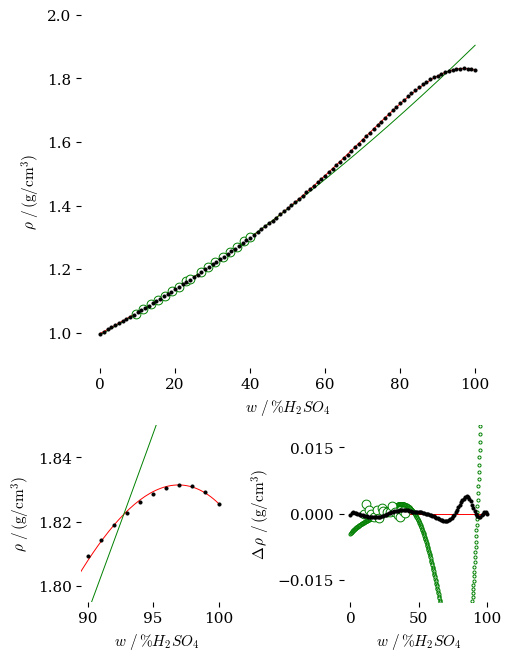

In [252]:
deg = 6
seed = 99

###################################################
### Create figure for plot with insets
###################################################


gs_kw = dict(width_ratios=[1, 1], height_ratios=[2, 1])
fig, axd = plt.subplot_mosaic([['top', 'top'],
                               ['left', 'right']],
                              gridspec_kw=gs_kw, figsize=(5, 6.5),
                              layout="constrained")


style = "tufte.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)


###################################################
### Get a Perry data
###################################################

Data_File_Name = "03_H2SO4_PercentWt_to_Density_Temp_Perry.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

Data_File_Name = "03_H2SO4_PercentWt_to_Density_Temp_Oca.csv"
Filename = github_location + Data_File_Name
df2 = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

x_oca = df2["%H2SO4"]
y_oca = df2["298.15K"]/1000

###################################################
### remove 25 data points from dataframe at random. Keep both sets.
###################################################

validate_df = df.sample(n=10, random_state=seed).sort_values(by="%H2SO4")
train_df = df.drop(validate_df.index)   

if 0:
    display(validate_df)
    display(train_df)

###################################################
### Fit a Polynomial Model to the training data
###################################################

#x = train_df["%H2SO4"]
#y = train_df["25C"]

x = df["%H2SO4"]
y = df["25C"]

# set weights for polynomial fit

weights = [1]*len(x)                         # create list of ones same length as x
#weights[-10:] = [10]*10                     # relace last 10 entries in list with 10
weights[-10:] = [1,2,3,4,5,6,7,8,9,10]       # replace last 10 entries in list
#weights[0:10] = [10]*10                     # relace first 10 entries in list with 10
weights[0:10] = [10,9,8,7,6,5,4,3,2,1]       # replace first 10 entries in list
#print(weights)
#weights = None                               # erase weights to do unweighted fit

# fit polynomial with weights
p = np.polyfit(x, y, deg, rcond=None, full=False, w=weights, cov=False)
print(p)

x1 = np.linspace(0,100,500)                  # x values for polynomial line
y1 = np.polyval(p, x1)


p1_matrix = [[1122, -0.5076, 2.484e-4],
             [976.4, -1.015],
             [237.8]]

def poly_oca(p,w,T):
        total = 0
        for i in range(len(p1_matrix)):
                for j in range(len(p1_matrix[i])):
                        total += p1_matrix[i][j]*w**i*T**j
        return total

y2 = poly_oca(p1_matrix, x1/100, 298.15)/1000                # y values for polynomial line with fixed coefficients 
y_oca2 = poly_oca(p1_matrix, x_oca, 298.15)/1000          # y values for oca w with fixed coefficients

###################################################
###################################################
###################################################
###################################################


###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$\rho\ / \,(\text{g/cm}^{3})$" 


###################################################
### Polynomial Fit Plot
###################################################

# Set up axes for main plot
axd["top"].set(ylabel=y_label, xlabel=x_label,
#        xlim=[-5,105],
        ylim=[0.89,2]
        )
# Data points for kobs vs Acidity

axd["top"].scatter(x, y, 
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 2)
axd["top"].plot(x1, y1,  
          color = "red", linewidth=0.7, 
          zorder = 1)
axd["top"].plot(x1, y2,  
          color = "green", linewidth=0.7, 
          zorder = 1)

axd["top"].scatter(x_oca*100, y_oca, 
          marker = "o", s = 40, 
          color = "white", edgecolors = "green", linewidths=0.7, 
          zorder = 1)



###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$\rho\ / \,(\text{g/cm}^{3})$" 


###################################################
### Plot results of polynomial fit - inset
###################################################


# Set up axes for main plot
axd["left"].set(ylabel=y_label, xlabel=x_label,
        xlim=[89.5,101],
        ylim=[1.795,1.85]
        )

axd["left"].scatter(x, y, 
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 5)
axd["left"].plot(x1, y1,  
          color = "red", linewidth=0.7, 
          zorder = 1)
axd["left"].plot(x1, y2,  
          color = "green", linewidth=0.7, 
          zorder = 1)


###################################################
###################################################
###################################################
###################################################




###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$\Delta\, \rho\ / \,(\text{g/cm}^{3})$" 


###################################################
### RATE vs ACIDITY Plot
###################################################

# Set up axes for main plot
axd["right"].set(ylabel=y_label, xlabel=x_label,
        xlim=[-5,105],
        ylim=[-0.02,0.02],
        yticks = [-0.015,0,0.015]       
        )
# Data points for kobs vs Acidit
###################################################
### calculate difference
###################################################
# x_diff = validate_df["%H2SO4"]
# y_diff = validate_df["25C"] - np.polyval(p, validate_df["%H2SO4"])

x_diff = x
y_diff = y - np.polyval(p, x_diff)

axd["right"].scatter(x_diff, y_diff, 
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 5)

x_diff = x1
y_diff = y2 - y1

axd["right"].scatter(x_diff, y_diff, 
          marker = "o", s = 5, 
          color = "white", edgecolors = "green", linewidths=0.7, 
          zorder = 2)

x_diff = x_oca * 100
y_diff = y_oca - y_oca2

axd["right"].scatter(x_diff, y_diff, 
          marker = "o", s = 40, 
          color = "white", edgecolors = "green", linewidths=0.7, 
          zorder = 2)

#axd["right"].plot(x_diff, y_diff,  
#          color = "black", linewidth=0.7, 
#          zorder = 1)
axd["right"].hlines(0, 0,100, color="red", linewidth=0.7, zorder = 0)   # horizontal line at y=0

#print(x_oca)
plt.savefig("plots/plot_B5A.pdf")
plt.show()


In [253]:
p1_matrix = [[1122, -0.5076, 2.484e-4],
             [976.4, -1.015],
             [237.8]]

total = 0
T = 273.15
w = 0.4
w = x_oca/100
for i in range(len(p1_matrix)):
    for j in range(len(p1_matrix[i])):
        print(f"{p1_matrix[i][j]}w^{i}T^{j}", end=" + ")
        total += p1_matrix[i][j]*w**i*T**j
#print(total)

1122w^0T^0 + -0.5076w^0T^1 + 0.0002484w^0T^2 + 976.4w^1T^0 + -1.015w^1T^1 + 237.8w^2T^0 + 

## Spline interpolation for density of H2SO4 using Perry Data

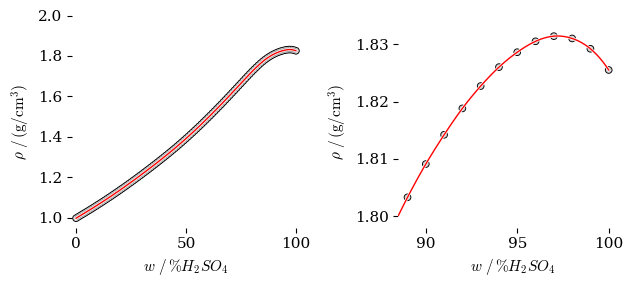

In [254]:

###################################################
### Get a Perry data
###################################################

Data_File_Name = "03_H2SO4_PercentWt_to_Density_Temp_Perry.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

Data_File_Name = "03_H2SO4_PercentWt_to_Density_Temp_Oca.csv"
Filename = github_location + Data_File_Name
df2 = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

x_oca = df2["%H2SO4"]
y_oca = df2["298.15K"]/1000

###################################################
### remove 25 data points from dataframe at random. Keep both sets.
###################################################

validate_df = df.sample(n=10, random_state=seed).sort_values(by="%H2SO4")
train_df = df.drop(validate_df.index)   

if 0:
    display(validate_df)
    display(train_df)

###################################################
### Fit a Polynomial Model to the training data
###################################################

#x = train_df["%H2SO4"]
#y = train_df["25C"]

x = df["%H2SO4"]
y = df["25C"]


interpolation = scipy.interpolate.make_interp_spline(x, y)

#interpolation = scipy.interpolate.Akima1DInterpolator(x, y, method = "akima")        
 
#interpolation = scipy.interpolate.make_smoothing_spline(x, y,   # The x and y data
#                                w=None,       # A list of weights for each point (default = None)
#                                lam=0.005        # A factor for the degree of smoothing. Change this to change the smoothness.
#                                )        

x1 = np.linspace(0, 100, 5000)                  # x values for polynomial line
y1interp = interpolation(x1)

style = "tufte.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[6.5,3])  
#ax2 = ax.twinx()

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$\rho\ / \,(\text{g/cm}^{3})$" 

ax[0].set(ylabel = y_label, 
          xlabel = x_label,
          xlim=[-2,102],
          ylim=[0.95,2]
        )

ax[0].scatter(x, y, 
          marker = "o", s = 30, 
          color = "black", edgecolors = "none", linewidths=0, 
          zorder = 3)

ax[0].scatter(x, y, 
          marker = "o", s = 17, 
          color = "white", edgecolors = "none", linewidths=0, 
          zorder = 4)

ax[0].scatter(x, y, 
          marker = "o", s = 17, 
          color = "black", edgecolors = "none", linewidths=0, 
          alpha = 0.2,
          zorder = 5)

ax[0].plot(x1,y1interp,zorder=10,linewidth=2,color="white")
ax[0].plot(x1,y1interp,zorder=10,linewidth=1,color="red")

#ax[0].vlines(100, -8.2, -13, linewidth=0.7, color="black", zorder = 0)

##################################

ax[1].set(ylabel=y_label, 
          xlabel=x_label,
          xlim=[88.5,101],
          ylim=[1.798,1.835]
        )

ax[1].scatter(x, y, 
          marker = "o", s = 30, 
          color = "black", edgecolors = "none", linewidths=0, 
          zorder = 3)

ax[1].scatter(x, y, 
          marker = "o", s = 17, 
          color = "white", edgecolors = "none", linewidths=0, 
          zorder = 4)

ax[1].scatter(x, y, 
          marker = "o", s = 17, 
          color = "black", edgecolors = "none", linewidths=0, 
          alpha = 0.2,
          zorder = 5)

ax[1].plot(x1,y1interp,zorder=10,linewidth=2,color="white")
ax[1].plot(x1,y1interp,zorder=10,linewidth=1,color="red")

ax[1].vlines(100, -8.2, -13, linewidth=0.7, color="black", zorder = 0)

##################################
plt.savefig("plots/plot_B6.pdf")
plt.show()


## Plotting $a_{H_2O}$

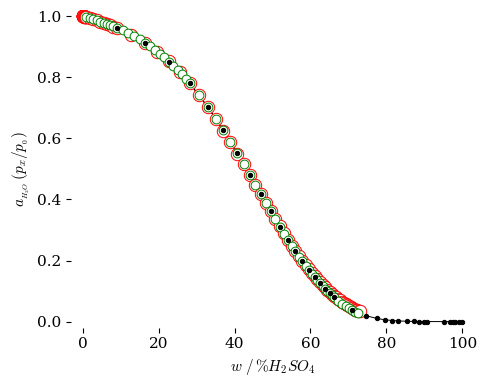

In [255]:
###################################################
### Create figure for plot
###################################################

style = "tufte.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$a_{_{H_2O}} \,({p_x}/{p_{_0}})$" 


###################################################
### Setup Plot
###################################################

# Set up axes for main plot

test = "C"   # A, B, or C

if test == "A":
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))  
    ax.set(ylabel=y_label, xlabel=x_label,
        xlim=[-1,31],
        ylim=[0.795,1.01],
        xticks = [0,10,20,30],
        yticks = [0.8,0.85,0.90,0.95,1.0]
        )
elif test == "B":   
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))  
    ax.set(ylabel=y_label, xlabel=x_label,
        xlim=[58,80],
        ylim=[-0.01,0.1],
        yticks = [0,0.05,0.10,0.15,0.20]
        )
elif test == "C":   
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  
    ax.set(ylabel=y_label, xlabel=x_label,
        xlim=[-3,103],
        ylim=[-0.02,1.02],
        yticks = [0,0.2,0.4,0.6,0.8,1.0]
        )
elif test == "D":   
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  
    ax.set(ylabel=y_label, xlabel=x_label,
        xlim=[89.95,100.05],
        ylim=[-1E-6,2E-4],
    #    yticks = []
        )

# Data points for kobs vs Acidity

###################################################
### Get and plot Giauque data
###################################################

Data_File_Name = "01_Giauque_Table9_activityH2OinH2SO4.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

### Convert Molal to PercentWt
### PercentWt = (molality * molwtH2SO4) / (molality * molwtH2SO4 + 1000) * 100
df["PercentWt_Calc"] = (df["conc H2SO4 / m"] * molwtH2SO4) / (df["conc H2SO4 / m"] * molwtH2SO4 + 1000) * 100 
dfg = df.copy()

x = dfg["PercentWt_Calc"]
y = dfg["aH2O"]

ax.plot(x, y,  
          color = "black", linewidth=0.7, 
          zorder = 3)

ax.scatter(x, y, 
          marker = "o", s = 10, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 6)


###################################################
### Get and plot Rhodes data
###################################################

Data_File_Name = "01_Rard_TableIV_activityH2OinH2SO4.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

### Convert Molal to PercentWt
### PercentWt = (molality * molwtH2SO4) / (molality * molwtH2SO4 + 1000) * 100
df["PercentWt_Calc"] = (df["conc H2SO4 / m"] * molwtH2SO4) / (df["conc H2SO4 / m"] * molwtH2SO4 + 1000) * 100 
dfr = df.copy()

x = dfr["PercentWt_Calc"]
y = dfr["aH2O"]

ax.plot(x, y,  
          color = "green", linewidth=0.7, 
          zorder = 2)

ax.scatter(x, y, 
         marker = "o", s = 40, 
         color = "white", edgecolors = "green", linewidths=0.7, 
         zorder = 5)


###################################################
### Get and plot Oca data
###################################################

Data_File_Name = "01_Staples_Table42_activityH2OinH2SO4.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

### Convert Molal to PercentWt
### PercentWt = (molality * molwtH2SO4) / (molality * molwtH2SO4 + 1000) * 100
df["PercentWt_Calc"] = (df["conc H2SO4 / m"] * molwtH2SO4) / (df["conc H2SO4 / m"] * molwtH2SO4 + 1000) * 100 
dfs = df.copy()

x = dfs["PercentWt_Calc"]
y = dfs["aH2O"]


ax.plot(x, y,  
          color = "red", linewidth=0.7, 
          zorder = 1)
ax.scatter(x, y, 
          marker = "o", s = 80, 
          color = "white", edgecolors = "red", linewidths=0.7, 
          zorder = 4)


plt.savefig("plots/plot_C1"+test+".pdf")
plt.show()


## Other Data Sets

Below we repeat the above using data from Giauque, Resnick and a Textbook (Drying). We see again that they might be all from the same model.

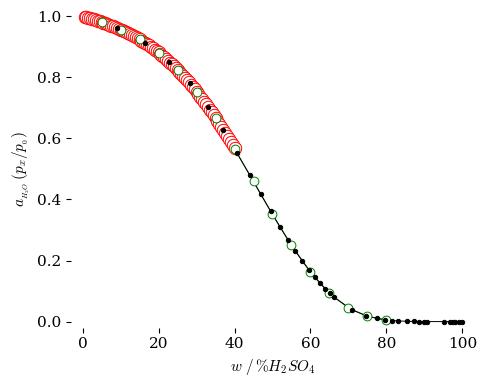

In [256]:
###################################################
### Create figure for plot
###################################################

style = "tufte.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$a_{_{H_2O}} \,({p_x}/{p_{_0}})$" 


###################################################
### Setup Plot
###################################################

# Set up axes for main plot

test = "C"   # A, B, or C

if test == "A":
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))  
    ax.set(ylabel=y_label, xlabel=x_label,
        xlim=[-1,31],
        ylim=[0.795,1.01],
        xticks = [0,10,20,30],
        yticks = [0.8,0.85,0.90,0.95,1.0]
        )
elif test == "B":   
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))  
    ax.set(ylabel=y_label, xlabel=x_label,
        xlim=[58,80],
        ylim=[-0.01,0.1],
        yticks = [0,0.05,0.10,0.15,0.20]
        )
elif test == "C":   
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  
    ax.set(ylabel=y_label, xlabel=x_label,
        xlim=[-3,103],
        ylim=[-0.02,1.02],
        yticks = [0,0.2,0.4,0.6,0.8,1.0]
        )
elif test == "D":   
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  
    ax.set(ylabel=y_label, xlabel=x_label,
        xlim=[89.95,100.05],
        ylim=[-1E-6,2E-4],
    #    yticks = []
        )

# Data points for kobs vs Acidity

###################################################
### Get and plot Giauque data
###################################################

Data_File_Name = "01_Giauque_Table9_activityH2OinH2SO4.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

### Convert Molal to PercentWt
### PercentWt = (molality * molwtH2SO4) / (molality * molwtH2SO4 + 1000) * 100
df["PercentWt_Calc"] = (df["conc H2SO4 / m"] * molwtH2SO4) / (df["conc H2SO4 / m"] * molwtH2SO4 + 1000) * 100 
dfg = df.copy()

x = dfg["PercentWt_Calc"]
y = dfg["aH2O"]

ax.plot(x, y,  
          color = "black", linewidth=0.7, 
          zorder = 3)

ax.scatter(x, y, 
          marker = "o", s = 10, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 6)


###################################################
### Get and plot Rhodes data
###################################################

Data_File_Name = "01_Drying_Table2.19_activityH2OinH2SO4.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

### Convert Molal to PercentWt
### PercentWt = (molality * molwtH2SO4) / (molality * molwtH2SO4 + 1000) * 100
#df["PercentWt_Calc"] = (df["conc H2SO4 / m"] * molwtH2SO4) / (df["conc H2SO4 / m"] * molwtH2SO4 + 1000) * 100 
dfr = df.copy()

x = dfr["w"]
y = dfr["25C"]

ax.plot(x, y,  
          color = "green", linewidth=0.7, 
          zorder = 2)

ax.scatter(x, y, 
         marker = "o", s = 40, 
         color = "white", edgecolors = "green", linewidths=0.7, 
         zorder = 5)


###################################################
### Get and plot Oca data
###################################################

Data_File_Name = "01_Resnick_Table4_activityH2OinH2SO4.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

### Convert Molal to PercentWt
### PercentWt = (molality * molwtH2SO4) / (molality * molwtH2SO4 + 1000) * 100
#df["PercentWt_Calc"] = (df["conc H2SO4 / m"] * molwtH2SO4) / (df["conc H2SO4 / m"] * molwtH2SO4 + 1000) * 100 
dfs = df.copy()

x = dfs["w"]
y = dfs["25C"]


ax.plot(x, y,  
          color = "red", linewidth=0.7, 
          zorder = 1)
ax.scatter(x, y, 
          marker = "o", s = 80, 
          color = "white", edgecolors = "red", linewidths=0.7, 
          zorder = 4)


plt.savefig("plots/plot_X1"+test+".pdf")
plt.show()


In [257]:
m = 15.5
(m * molwtH2SO4) / (m * molwtH2SO4 + 1000) * 100 


60.32099521292646

## Merge Data Sets

The code below will merge the data sets for data/01_Rard_TableIV_activityH2OinH2SO4.csv and data/01_Giauque_Table9_activityH2OinH2SO4.csv



In [258]:
Data_File_Name = "01_Giauque_Table9_activityH2OinH2SO4.csv"
Filename = github_location + Data_File_Name
dfg = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 
Data_File_Name = "01_Rard_TableIV_activityH2OinH2SO4.csv"
Filename = github_location + Data_File_Name
dfr = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#")

# rename columns to avoid confusion
dfg = dfg.rename(columns={"conc H2SO4 / m": "m"})
dfr = dfr.rename(columns={"conc H2SO4 / m": "m"})

 # keep only columns "m" and "aH2O"
dfg = dfg[["m", "aH2O"]]
dfr = dfr[["m", "aH2O"]]


# concatenate dataframes and remove duplicate rows
#df = pd.concat([dfg, dfr]).drop_duplicates(subset="m", keep="last").sort_values(by="m").reset_index(drop=True)
df = pd.concat([dfg, dfr]).sort_values(by="m").reset_index(drop=True)
display(df.head(5))
df.to_csv(github_location+"aH2O_data.csv")   

,m,aH2O
0,0.1,0.99633
1,0.2,0.99284
2,0.3,0.98928
3,0.4,0.98564
4,0.5,0.98192


## Attempt Polynomial Fit

The final values of the data set are tiny. Any squigles in the polynomial fit are disastrous. There was no degree that seemed to solve the problem. I will need to use smaller ranges and a piecewise fit.

weights
0      1.003684e+00
1      1.007212e+00
2      1.010836e+00
3      1.014569e+00
4      1.018413e+00
           ...     
96     7.246377e+04
97     1.270648e+05
98     1.923077e+05
99     6.666667e+05
100    6.410256e+08
Name: aH2O, Length: 101, dtype: float64

0     -0.689946
1     -0.159176
2      0.167387
3      0.342752
4      0.409716
         ...   
96     1.538399
97     0.056960
98    -1.119922
99     0.228299
100    0.048756
Name: aH2O, Length: 101, dtype: float64


/var/folders/g4/31rdj0dn7r7bkb_cp76b2zsr0000gn/T/ipykernel_6843/3526387101.py:56: RankWarning: Polyfit may be poorly conditioned
  p = np.polyfit(x, y, deg, rcond=None, full=False, w=weights, cov=False)


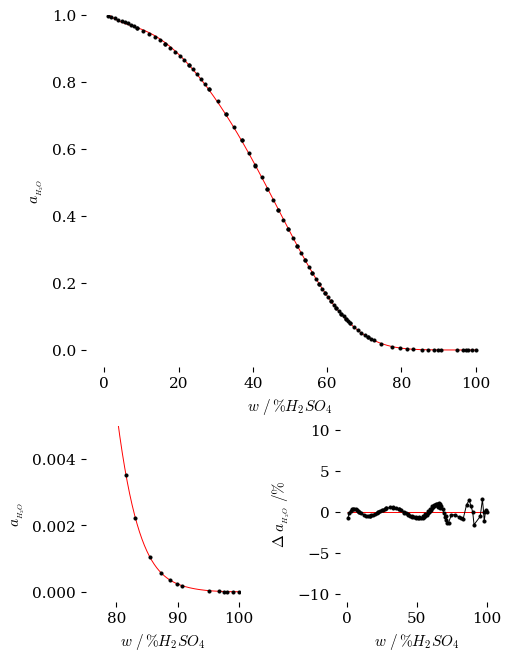

w,         aH2O,       aH2O_fit,         diff,       %diff
  0.9713,  0.9963,     1.003,     -0.006874,     -0.6899
   1.924,  0.9928,    0.9944,      -0.00158,     -0.1592
   2.858,  0.9893,    0.9876,      0.001656,      0.1674
   3.775,  0.9856,    0.9823,      0.003378,      0.3428
   4.675,  0.9819,    0.9779,      0.004023,      0.4097
   5.558,  0.9781,    0.9742,      0.003921,      0.4009
   6.424,  0.9742,    0.9709,      0.003337,      0.3425
   7.275,  0.9702,    0.9677,      0.002462,      0.2537
   8.111,  0.9661,    0.9647,      0.001437,      0.1488
   8.932,  0.9622,    0.9615,     0.0006964,     0.07237
   8.932,  0.9619,    0.9615,     0.0003764,     0.03913
   10.53,  0.9531,    0.9547,     -0.001579,     -0.1657
   12.07,  0.9438,    0.9469,     -0.003058,      -0.324
   13.56,   0.934,     0.938,     -0.003959,     -0.4238
   15.01,  0.9237,     0.928,     -0.004281,     -0.4635
    16.4,   0.913,     0.917,     -0.003992,     -0.4373
    16.4,  0.9129,     0.917,

In [259]:
deg = 12

###################################################
### Create figure for plot with insets
###################################################

gs_kw = dict(width_ratios=[1, 1], height_ratios=[2, 1])
fig, axd = plt.subplot_mosaic([['top', 'top'],
                               ['left', 'right']],
                              gridspec_kw=gs_kw, figsize=(5, 6.5),
                              layout="constrained")

style = "tufte.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

###################################################
### Get a Perry data
###################################################

Data_File_Name = "aH2O_data.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

###################################################
### Fit a Polynomial Model to the training data
###################################################

### Convert Molal to PercentWt
### PercentWt = (molality * molwtH2SO4) / (molality * molwtH2SO4 + 1000) * 100
df["PercentWt_Calc"] = (df["m"] * molwtH2SO4) / (df["m"] * molwtH2SO4 + 1000) * 100 


x = df["PercentWt_Calc"]
y = df["aH2O"]

# set weights for polynomial fit

weights = [1]*len(x)                         # create list of ones same length as x
#weights[-10:] = [10]*10                     # relace last 10 entries in list with 10
weights[-16:] = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]       # replace last 10 entries in list
#weights[0:10] = [10]*10                     # relace first 10 entries in list with 10
#weights[0:10] = [10,9,8,7,6,5,4,3,2,1]       # replace first 10 entries in list
#print(weights)
weights = 1/y                               # erase weights to do unweighted fit

print("weights")
print(weights)
print()

# fit polynomial with weights
p = np.polyfit(x, y, deg, rcond=None, full=False, w=weights, cov=False)

x1 = np.linspace(0,100,500)                  # x values for polynomial line
y1 = np.polyval(p, x1)


###################################################
###################################################
###################################################
###################################################


###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$a_{_{H_2O}}$" 


###################################################
### Polynomial Fit Plot
###################################################

# Set up axes for main plot
axd["top"].set(ylabel=y_label, xlabel=x_label,
        xlim=[-5,105],
        ylim=[-0.05,1]
        )
# Data points for kobs vs Acidity

axd["top"].scatter(x, y, 
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 2)
axd["top"].plot(x1, y1,  
          color = "red", linewidth=0.7, 
          zorder = 1)



###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$a_{_{H_2O}}$" 


###################################################
### Plot results of polynomial fit - inset
###################################################


# Set up axes for main plot
#axd["left"].set(ylabel=y_label, xlabel=x_label,
#        xlim=[69.5,101],
#        ylim=[-0.03,0.1]
#        )
#axd["left"].set(ylabel=y_label, xlabel=x_label,
#        xlim=[84.5,100.2],
#        ylim=[-0.00005,0.0005],
#        xticks = [85,90,95,100]
#        )
axd["left"].set(ylabel=y_label, xlabel=x_label,
        xlim=[75,100.2],
        ylim=[-0.0003,0.005]
        )

axd["left"].scatter(x, y, 
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 5)
axd["left"].plot(x1, y1,  
          color = "red", linewidth=0.7, 
          zorder = 1)


###################################################
###################################################
###################################################
###################################################




###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$\Delta\;a_{_{H_2O}}\ /\%$" 


###################################################
### RATE vs ACIDITY Plot
###################################################

# Set up axes for main plot
axd["right"].set(ylabel=y_label, xlabel=x_label,
        xlim=[-5,105],
        ylim=[-10.9,10.5],
#        yticks = [-0.015,0,0.015]       
        )
# Data points for kobs vs Acidit
###################################################
### calculate difference
###################################################
# x_diff = validate_df["%H2SO4"]
# y_diff = validate_df["25C"] - np.polyval(p, validate_df["%H2SO4"])

x_diff = x
y_diff = (y - np.polyval(p, x_diff))/y*100
print(y_diff)
axd["right"].scatter(x_diff, y_diff, 
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 5)

axd["right"].plot(x_diff, y_diff,  
          color = "black", linewidth=0.7, 
          zorder = 1)
axd["right"].hlines(0, 0,100, color="red", linewidth=0.7, zorder = 0)   # horizontal line at y=0

#print(x_oca)
plt.savefig("plots/plot_D1.pdf")
plt.show()

iter = zip(x_diff, y, np.polyval(p, x_diff), y-np.polyval(p, x_diff), y_diff)
print("w,         aH2O,       aH2O_fit,         diff,       %diff")
for a,b,c,d,e in iter: print(f"{a:8.4g},{b:8.4g},{c:10.4g},{d:14.4g},{e:12.4g}")

print(f"Average error: {(y-np.polyval(p, x_diff)).abs().median():8.4g}")

[1.3144390986547206e-10, -7.66081531958916e-08, 1.861606393982286e-05, -0.0024144046707908805, 0.17627444573467085, -6.869563087739767, 111.64775033088463]
>=85

0    -0.002589
1     0.084151
2    -0.167452
3     0.202973
4    -0.099003
5     0.082905
6     0.022831
7    -0.314452
8     0.109556
9     0.439401
10   -1.184018
Name: aH2O, dtype: float64


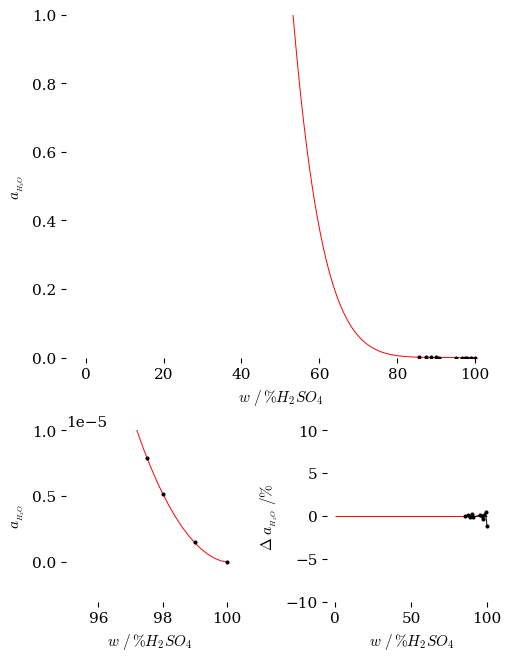

array([1.04031807e-03, 5.71605951e-04, 3.58489077e-04, 2.47080153e-04,
       1.81737957e-04, 3.21682989e-05, 1.35877010e-05, 7.86551722e-06,
       5.25823595e-06, 1.49657551e-06, 1.55923940e-09])

In [260]:
deg = 6
import json

###################################################
### Create figure for plot with insets
###################################################

gs_kw = dict(width_ratios=[1, 1], height_ratios=[2, 1])
fig, axd = plt.subplot_mosaic([['top', 'top'],
                               ['left', 'right']],
                              gridspec_kw=gs_kw, figsize=(5, 6.5),
                              layout="constrained")

style = "tufte.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

###################################################
### Get a Perry data
###################################################

Data_File_Name = "aH2O_data.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

###################################################
### Fit a Polynomial Model to the training data
###################################################

### Convert Molal to PercentWt
### PercentWt = (molality * molwtH2SO4) / (molality * molwtH2SO4 + 1000) * 100
df["PercentWt_Calc"] = (df["m"] * molwtH2SO4) / (df["m"] * molwtH2SO4 + 1000) * 100 

########
n = 85
########

#keep only rows where PercentWt_Calc >= n
df = df[df["PercentWt_Calc"] >= n].reset_index(drop=True)


x = df["PercentWt_Calc"]
y = df["aH2O"]

# set weights for polynomial fit

weights = [1]*len(x)                         # create list of ones same length as x
#weights[-10:] = [10]*10                     # relace last 10 entries in list with 10
weights[-10:] = [1,2,3,4,5,6,7,8,9,100]       # replace last 10 entries in list
#weights[0:10] = [10]*10                     # relace first 10 entries in list with 10
#weights[0:10] = [10,9,8,7,6,5,4,3,2,1]       # replace first 10 entries in list
#print(weights)
#weights = None                               # erase weights to do unweighted fit

# fit polynomial with weights
p1 = np.polyfit(x, y, deg, rcond=None, full=False, w=weights, cov=False)
print(json.dumps(p1.tolist()))

print(">=85")
print()

x1 = np.linspace(0,100,500)                  # x values for polynomial line
y1 = np.polyval(p1, x1)


###################################################
###################################################
###################################################
###################################################


###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$a_{_{H_2O}}$" 


###################################################
### Polynomial Fit Plot
###################################################

# Set up axes for main plot
axd["top"].set(ylabel=y_label, xlabel=x_label,
#        xlim=[-5,105],
        ylim=[0,1]
        )
# Data points for kobs vs Acidity

axd["top"].scatter(x, y, 
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 2)
axd["top"].plot(x1, y1,  
          color = "red", linewidth=0.7, 
          zorder = 1)



###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$a_{_{H_2O}}$" 


###################################################
### Plot results of polynomial fit - inset
###################################################


# Set up axes for main plot
#axd["left"].set(ylabel=y_label, xlabel=x_label,
#        xlim=[69.5,101],
#        ylim=[-0.03,0.1]
#        )
axd["left"].set(ylabel=y_label, xlabel=x_label,
        xlim=[95,100.2],
        ylim=[-0.000003,0.00001]
        )

axd["left"].scatter(x, y, 
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 5)
axd["left"].plot(x1, y1,  
          color = "red", linewidth=0.7, 
          zorder = 1)


###################################################
###################################################
###################################################
###################################################




###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$\Delta\;a_{_{H_2O}}\ /\%$" 


###################################################
### RATE vs ACIDITY Plot
###################################################

# Set up axes for main plot
axd["right"].set(ylabel=y_label, xlabel=x_label,
        xlim=[-5,105],
        ylim=[-10,10],
#        yticks = [-0.015,0,0.015]       
        )
# Data points for kobs vs Acidit
###################################################
### calculate difference
###################################################
# x_diff = validate_df["%H2SO4"]
# y_diff = validate_df["25C"] - np.polyval(p, validate_df["%H2SO4"])

x_diff = x
y_diff = (y - np.polyval(p1, x_diff))/y*100
print(y_diff)
axd["right"].scatter(x_diff, y_diff, 
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 5)

axd["right"].plot(x_diff, y_diff,  
          color = "black", linewidth=0.7, 
          zorder = 1)
axd["right"].hlines(0, 0,100, color="red", linewidth=0.7, zorder = 0)   # horizontal line at y=0

#print(x_oca)
plt.savefig("plots/plot_C2.pdf")
plt.show()
np.polyval(p, x)

[3.5028296204346276e-20, -1.3865886137076893e-17, 2.400749341678086e-15, -2.3864158758420187e-13, 1.503635156652536e-11, -6.266897700525367e-10, 1.7536108094004455e-08, -3.2658573058761877e-07, 3.926131300883647e-06, -3.2632125025102435e-05, 7.228976395942948e-05, -0.0037583937133600694, 0.9999602819064616]
0 to <60
0    -0.002149
1     0.002928
2     0.002551
3     0.000178
4    -0.001889
        ...   
63    0.141050
64   -0.064280
65   -0.028327
66    0.044822
67   -0.034887
Name: aH2O, Length: 68, dtype: float64


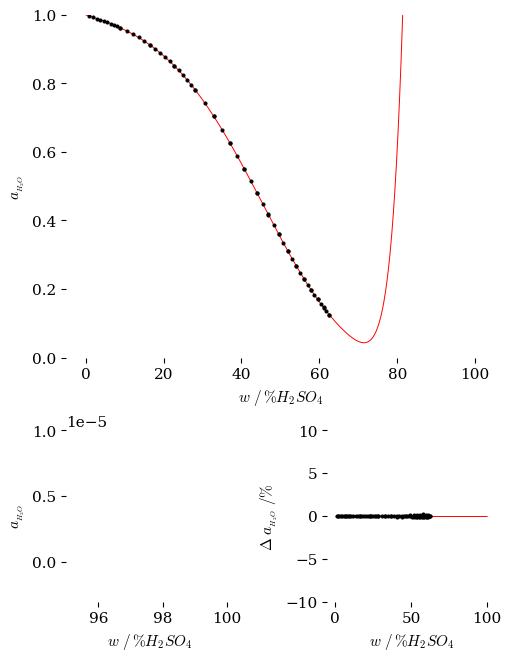

In [261]:
deg = 12
import json
###################################################
### Create figure for plot with insets
###################################################

gs_kw = dict(width_ratios=[1, 1], height_ratios=[2, 1])
fig, axd = plt.subplot_mosaic([['top', 'top'],
                               ['left', 'right']],
                              gridspec_kw=gs_kw, figsize=(5, 6.5),
                              layout="constrained")

style = "tufte.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

###################################################
### Get a Perry data
###################################################

Data_File_Name = "aH2O_data.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

###################################################
### Fit a Polynomial Model to the training data
###################################################

### Convert Molal to PercentWt
### PercentWt = (molality * molwtH2SO4) / (molality * molwtH2SO4 + 1000) * 100
df["PercentWt_Calc"] = (df["m"] * molwtH2SO4) / (df["m"] * molwtH2SO4 + 1000) * 100 

########
n = 63
########

#keep only rows where PercentWt_Calc < n
df = df[df["PercentWt_Calc"] < n].reset_index(drop=True)


x = df["PercentWt_Calc"]
y = df["aH2O"]

# set weights for polynomial fit

weights = [1]*len(x)                         # create list of ones same length as x
#weights[-10:] = [10]*10                     # relace last 10 entries in list with 10
weights[-10:] = [1,2,3,4,5,6,7,8,9,100]       # replace last 10 entries in list
#weights[0:10] = [10]*10                     # relace first 10 entries in list with 10
#weights[0:10] = [10,9,8,7,6,5,4,3,2,1]       # replace first 10 entries in list
#print(weights)
weights = None                               # erase weights to do unweighted fit

# fit polynomial with weights
p3 = np.polyfit(x, y, deg, rcond=None, full=False, w=weights, cov=False)
print(json.dumps(p3.tolist()))
print("0 to <60")

x1 = np.linspace(0,100,500)                  # x values for polynomial line
y1 = np.polyval(p3, x1)


###################################################
###################################################
###################################################
###################################################


###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$a_{_{H_2O}}$" 


###################################################
### Polynomial Fit Plot
###################################################

# Set up axes for main plot
axd["top"].set(ylabel=y_label, xlabel=x_label,
#        xlim=[-5,105],
        ylim=[0,1]
        )
# Data points for kobs vs Acidity

axd["top"].scatter(x, y, 
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 2)
axd["top"].plot(x1, y1,  
          color = "red", linewidth=0.7, 
          zorder = 1)



###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$a_{_{H_2O}}$" 


###################################################
### Plot results of polynomial fit - inset
###################################################


# Set up axes for main plot
#axd["left"].set(ylabel=y_label, xlabel=x_label,
#        xlim=[69.5,101],
#        ylim=[-0.03,0.1]
#        )
axd["left"].set(ylabel=y_label, xlabel=x_label,
        xlim=[95,100.2],
        ylim=[-0.000003,0.00001]
        )

axd["left"].scatter(x, y, 
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 5)
axd["left"].plot(x1, y1,  
          color = "red", linewidth=0.7, 
          zorder = 1)


###################################################
###################################################
###################################################
###################################################




###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$\Delta\;a_{_{H_2O}}\ /\%$" 


###################################################
### RATE vs ACIDITY Plot
###################################################

# Set up axes for main plot
axd["right"].set(ylabel=y_label, xlabel=x_label,
        xlim=[-5,105],
        ylim=[-10,10],
#        yticks = [-0.015,0,0.015]       
        )
# Data points for kobs vs Acidit
###################################################
### calculate difference
###################################################
# x_diff = validate_df["%H2SO4"]
# y_diff = validate_df["25C"] - np.polyval(p, validate_df["%H2SO4"])

x_diff = x
y_diff = (y - np.polyval(p3, x_diff))/y*100
print(y_diff)
axd["right"].scatter(x_diff, y_diff, 
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 5)

axd["right"].plot(x_diff, y_diff,  
          color = "black", linewidth=0.7, 
          zorder = 1)
axd["right"].hlines(0, 0,100, color="red", linewidth=0.7, zorder = 0)   # horizontal line at y=0

#print(x_oca)
plt.savefig("plots/plot_C2.pdf")
plt.show()


>=60 to <85
[5.273694450545175e-12, -3.202122480780035e-09, 8.478735052157742e-07, -0.0001278604537833294, 0.012009560859777895, -0.7193856069830259, 26.8355457911388, -569.97502173756, 5278.099422529045]
0    -0.104939
1     0.206579
2     0.001384
3     0.012243
4     0.028125
5    -0.051598
6    -0.038206
7    -0.055212
8    -0.148113
9     0.034254
10   -0.323500
11    0.076928
12    0.211062
13   -0.273776
14    0.242062
15    0.335542
16    0.345199
17    0.259806
18    0.051239
19    0.406601
20   -0.094000
21   -0.228942
22   -0.183783
23    0.382637
24   -0.241238
25   -0.129853
26    0.437004
27   -0.289050
28    0.050102
Name: aH2O, dtype: float64


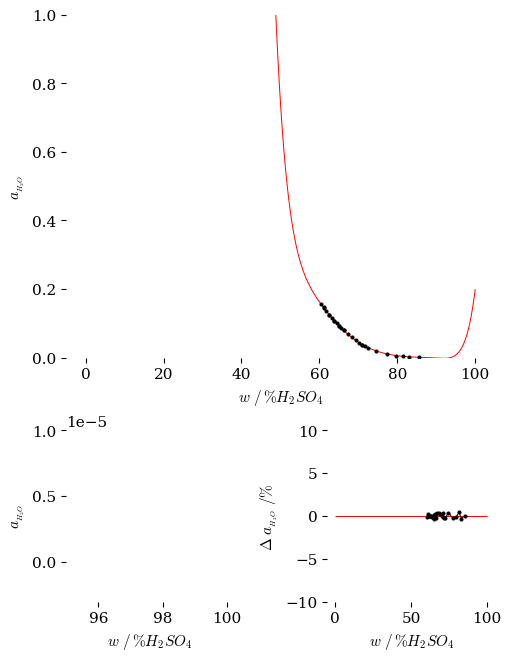

In [262]:
deg = 8
import json
###################################################
### Create figure for plot with insets
###################################################

gs_kw = dict(width_ratios=[1, 1], height_ratios=[2, 1])
fig, axd = plt.subplot_mosaic([['top', 'top'],
                               ['left', 'right']],
                              gridspec_kw=gs_kw, figsize=(5, 6.5),
                              layout="constrained")

style = "tufte.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

###################################################
### Get a Perry data
###################################################

Data_File_Name = "aH2O_data.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

###################################################
### Fit a Polynomial Model to the training data
###################################################

### Convert Molal to PercentWt
### PercentWt = (molality * molwtH2SO4) / (molality * molwtH2SO4 + 1000) * 100
df["PercentWt_Calc"] = (df["m"] * molwtH2SO4) / (df["m"] * molwtH2SO4 + 1000) * 100 

########
n = 60
m = 87
########

#keep only rows where PercentWt_Calc is between n and m
df = df[(df["PercentWt_Calc"] >= n) & (df["PercentWt_Calc"] < m)].reset_index(drop=True)



x = df["PercentWt_Calc"]
y = df["aH2O"]

# set weights for polynomial fit

weights = [1]*len(x)                         # create list of ones same length as x
#weights[-10:] = [10]*10                     # relace last 10 entries in list with 10
weights[-10:] = [1,2,3,4,5,6,7,8,9,10]       # replace last 10 entries in list
#weights[0:10] = [10]*10                     # relace first 10 entries in list with 10
#weights[0:10] = [10,9,8,7,6,5,4,3,2,1]       # replace first 10 entries in list
#print(weights)
#weights = None                               # erase weights to do unweighted fit

# fit polynomial with weights
p2 = np.polyfit(x, y, deg, rcond=None, full=False, w=weights, cov=False)

print(">=60 to <85")
print(json.dumps(p2.tolist()))

x1 = np.linspace(0,100,500)                  # x values for polynomial line
y1 = np.polyval(p2, x1)


###################################################
###################################################
###################################################
###################################################


###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$a_{_{H_2O}}$" 


###################################################
### Polynomial Fit Plot
###################################################

# Set up axes for main plot
axd["top"].set(ylabel=y_label, xlabel=x_label,
#        xlim=[-5,105],
        ylim=[0,1]
        )
# Data points for kobs vs Acidity

axd["top"].scatter(x, y, 
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 2)
axd["top"].plot(x1, y1,  
          color = "red", linewidth=0.7, 
          zorder = 1)



###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$a_{_{H_2O}}$" 


###################################################
### Plot results of polynomial fit - inset
###################################################


# Set up axes for main plot
#axd["left"].set(ylabel=y_label, xlabel=x_label,
#        xlim=[69.5,101],
#        ylim=[-0.03,0.1]
#        )
axd["left"].set(ylabel=y_label, xlabel=x_label,
        xlim=[95,100.2],
        ylim=[-0.000003,0.00001]
        )

axd["left"].scatter(x, y, 
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 5)
axd["left"].plot(x1, y1,  
          color = "red", linewidth=0.7, 
          zorder = 1)


###################################################
###################################################
###################################################
###################################################




###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$\Delta\;a_{_{H_2O}}\ /\%$" 


###################################################
### RATE vs ACIDITY Plot
###################################################

# Set up axes for main plot
axd["right"].set(ylabel=y_label, xlabel=x_label,
        xlim=[-5,105],
        ylim=[-10,10],
#        yticks = [-0.015,0,0.015]       
        )
# Data points for kobs vs Acidit
###################################################
### calculate difference
###################################################
# x_diff = validate_df["%H2SO4"]
# y_diff = validate_df["25C"] - np.polyval(p, validate_df["%H2SO4"])

x_diff = x
y_diff = (y - np.polyval(p2, x_diff))/y*100
print(y_diff)
axd["right"].scatter(x_diff, y_diff, 
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 5)

axd["right"].plot(x_diff, y_diff,  
          color = "black", linewidth=0.7, 
          zorder = 1)
axd["right"].hlines(0, 0,100, color="red", linewidth=0.7, zorder = 0)   # horizontal line at y=0

#print(x_oca)
plt.savefig("plots/plot_C2.pdf")
plt.show()


## Build Model

The code below establishes the model using the coefficinets in each region above.

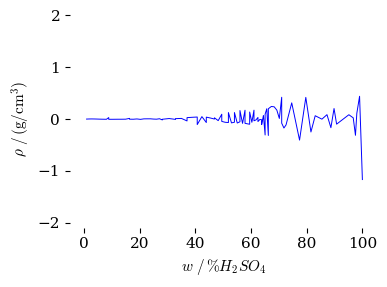

np.float64(1.578072783559037e-09)

In [263]:
# Create piecewise polynomial fit for entire range 0-100
# Full precision coefficients from fitting in three segments
# The full precision coefficients are needed to avoid extreme errors in
# the high concentration regions where the predicted values are very small.

def piecewise_85_100(x: float) -> float:
    """Scalar piecewise polynomial evaluator."""

    # polynomial coefficients for range 85-100
    p1 = [1.3144404858464668e-10, 
         -7.660823213573518e-08, 
          1.8616082649198916e-05, 
         -0.002414407034715221, 
          0.1762746136695284, 
         -6.8695694477137055, 
        111.64785064569885]
              
#    x = float(x)
#    return float(np.polyval(p1, x))
    return np.polyval(p1, x)

def piecewise_60_85(x: float) -> float:
    """Scalar piecewise polynomial evaluator."""

    # polynomial coefficients for range 60-85
    p2 = [-1.3624463383155488e-11, 
           7.672094619025286e-09, 
          -1.884807056101815e-06, 
           0.0002638547059437287, 
          -0.023021682334033254, 
           1.282041898915145, 
         -44.50222158105233, 
         880.3763709481067, 
       -7598.898765490027]
                                    
#    x = float(x)
    return np.polyval(p2, x)

def piecewise_0_60(x: float) -> float:
    """Scalar piecewise polynomial evaluator."""

    # polynomial coefficients for range 0-60
    p3 = [-5.773338829443844e-20, 
           1.9241107621485452e-17, 
          -2.7809385013788315e-15, 
           2.2882355299128215e-13, 
          -1.183883807684228e-11, 
           4.0121074846344075e-10, 
          -8.975126614993668e-09, 
           1.3113349498962367e-07, 
          -1.2213930921579994e-06, 
           3.1589777766395234e-06, 
          -6.821487617101951e-05, 
          -0.003494581979577625, 
           0.9997966670703163]

#    x = float(x)
    return np.polyval(p3, x)


def piecewise_poly(x: float) -> float:
    """Scalar piecewise polynomial evaluator."""


    x = float(x)
    if x >= 85:
        return float(piecewise_85_100(x))
    elif x <= 60:
        return float(piecewise_0_60(x))
    else:
        return float(piecewise_60_85(x))
    

def v_piecewise_poly(x):
    """Vectorized piecewise polynomial evaluator. Accepts array-like x."""
    xa = np.asarray(x, dtype=float)
    y = np.empty_like(xa, dtype=float)
    cond1 = xa >= 85
    cond2 = (xa >= 60) & (xa < 85)
    cond3 = xa < 60
    if cond1.any():
        y[cond1] = piecewise_85_100(xa[cond1])
    if cond2.any():
        y[cond2] = piecewise_60_85(xa[cond2])
    if cond3.any():
        y[cond3] = piecewise_0_60(xa[cond3])
    return y
    




Data_File_Name = "aH2O_data.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

###################################################
### Fit a Polynomial Model to the training data
###################################################

### Convert Molal to PercentWt
### PercentWt = (molality * molwtH2SO4) / (molality * molwtH2SO4 + 1000) * 100
df["PercentWt_Calc"] = (df["m"] * molwtH2SO4) / (df["m"] * molwtH2SO4 + 1000) * 100 

x = df["PercentWt_Calc"]
y = df["aH2O"]


y1 = (y-v_piecewise_poly(x))/y*100

plt.plot(x, y1,  
          color = "blue", linewidth=0.7, 
          zorder = 1)






#x1 = np.linspace(0,100,500)                  # x values for polynomial line
#y1 = v_piecewise_poly(x1)
#plt.plot(x1, y1,  
#          color = "blue", linewidth=0.7, 
#          zorder = 1)
#plt.scatter(x, y, 
#          marker = "o", s = 5, 
#          color = "black", edgecolors = "black", linewidths=0.7, 
#          zorder = 2)




plt.ylim(-2.1,2.1)
plt.xlim(-5,105)
plt.ylabel(r"$\rho\ / \,(\text{g/cm}^{3})$")
plt.xlabel(r"$w\ /\,\%H_2SO_4$")
plt.savefig("plots/plot_C3.pdf")
plt.show()  

np.polyval(p1, 100)

## Piecewise for aH2O whole range

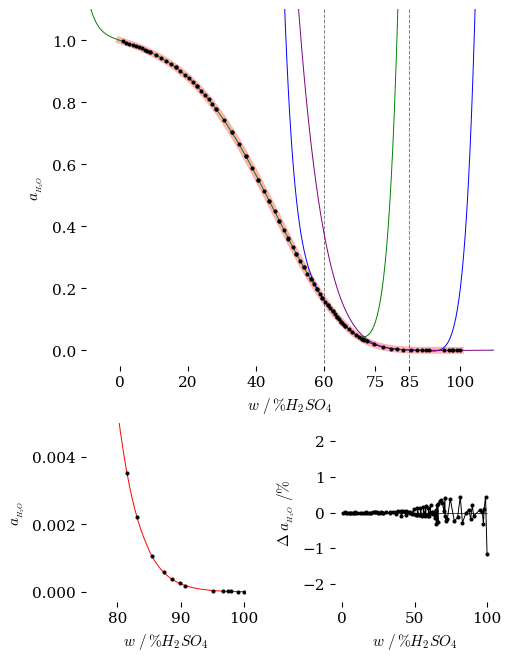

-0.05101027393220155


In [264]:
# Create piecewise polynomial fit for entire range 0-100
# Full precision coefficients from fitting in three segments
# The full precision coefficients are needed to avoid extreme errors in
# the high concentration regions where the predicted values are very small.

def piecewise_85_100(x: float) -> float:
    """Scalar piecewise polynomial evaluator."""

    # polynomial coefficients for range 85-100
    p1 = [1.3144404858464668e-10, 
         -7.660823213573518e-08, 
          1.8616082649198916e-05, 
         -0.002414407034715221, 
          0.1762746136695284, 
         -6.8695694477137055, 
        111.64785064569885]
              
#    x = float(x)
#    return float(np.polyval(p1, x))
    return np.polyval(p1, x)

def piecewise_60_85(x: float) -> float:
    """Scalar piecewise polynomial evaluator."""

    # polynomial coefficients for range 60-85
    p2 = [5.273726317476769e-12, 
          -3.2021412494451217e-09, 
          8.478783316886211e-07, 
          -0.0001278611615731464, 
          0.01200962559880584, 
          -0.7193893888613687, 
          26.83568358232527, 
          -569.9778844885892, 
          5278.125388514924]



#    x = float(x)
    return np.polyval(p2, x)

def piecewise_0_60(x: float) -> float:
    """Scalar piecewise polynomial evaluator."""

    # polynomial coefficients for range 0-60
    p3 = [3.5028296585578643e-20, 
          -1.3865886286472502e-17, 
          2.400749367443683e-15, 
          -2.3864159015620214e-13, 
          1.5036351730947478e-11, 
          -6.266897770870015e-10, 
          1.7536108298451186e-08, 
          -3.2658573460234344e-07, 
          3.9261313528507605e-06, 
          -3.2632125447469756e-05, 
          7.228976593850476e-05, 
          -0.00375839371793719, 
          0.9999602819100265]


#    x = float(x)
    return np.polyval(p3, x)


def piecewise_poly(x: float) -> float:
    """Scalar piecewise polynomial evaluator."""


    x = float(x)
    if x >= 85:
        return float(piecewise_85_100(x))
    elif x <= 60:
        return float(piecewise_0_60(x))
    else:
        return float(piecewise_60_85(x))
    

def v_piecewise_poly(x):
    """Vectorized piecewise polynomial evaluator. Accepts array-like x."""
    xa = np.asarray(x, dtype=float)
    y = np.empty_like(xa, dtype=float)
    cond1 = xa >= 85.0
    cond2 = (xa >= 60.0) & (xa < 85.0)
    cond3 = xa < 60.0
    if cond1.any():
        y[cond1] = piecewise_85_100(xa[cond1])
    if cond2.any():
        y[cond2] = piecewise_60_85(xa[cond2])
    if cond3.any():
        y[cond3] = piecewise_0_60(xa[cond3])
    return y

###############################################################################

deg = 8
import json
###################################################
### Create figure for plot with insets
###################################################

gs_kw = dict(width_ratios=[1, 1], height_ratios=[2, 1])
fig, axd = plt.subplot_mosaic([['top', 'top'],
                               ['left', 'right']],
                              gridspec_kw=gs_kw, figsize=(5, 6.5),
                              layout="constrained")

style = "tufte.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

###################################################
### Get a Giauque data
###################################################

Data_File_Name = "aH2O_data.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

###################################################
### Fit a Polynomial Model to the training data
###################################################

### Convert Molal to PercentWt
### PercentWt = (molality * molwtH2SO4) / (molality * molwtH2SO4 + 1000) * 100
df["PercentWt_Calc"] = (df["m"] * molwtH2SO4) / (df["m"] * molwtH2SO4 + 1000) * 100 

x = df["PercentWt_Calc"]
y = df["aH2O"]


y_diff_percent = (y-v_piecewise_poly(x))/y*100

x1 = np.linspace(-10,110,521)                  # x values for polynomial line
x1a = np.clip(x1, 0, 100)                     # clip x values to valid range 0-100

y1 = v_piecewise_poly(x1a)

y_60 = piecewise_0_60(x1)
y_60_85 = piecewise_60_85(x1)
y_85 = piecewise_85_100(x1)



###################################################
###################################################
###################################################
###################################################


###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$a_{_{H_2O}}$" 


###################################################
### Polynomial Fit Plot
###################################################

# Set up axes for main plot
axd["top"].set(ylabel=y_label, xlabel=x_label,
        xlim=[-10,110],
        ylim=[-0.05,1.1],
        xticks = [0,20,40,60,75,85, 100]
        )
# Data points for kobs vs Acidity

axd["top"].scatter(x, y, 
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 2)
axd["top"].plot(x1a, y1,  
          color = "red", alpha = 0.3, linewidth=5, 
          zorder = 1)
axd["top"].plot(x1, y_60,  
          color = "green", linewidth=0.7, 
          zorder = 1)
axd["top"].plot(x1, y_60_85,  
          color = "blue", linewidth=0.7, 
          zorder = 1)
axd["top"].plot(x1, y_85,  
          color = "purple", linewidth=0.7, 
          zorder = 1)
axd["top"].vlines(60, -0.04,1.1, color="grey", linewidth=0.7, zorder = 0, linestyles='dashed')   # vertical line at x=60
axd["top"].vlines(85, -0.04,1.1, color="grey", linewidth=0.7, zorder = 0, linestyles='dashed')   # vertical line at x=85

###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$a_{_{H_2O}}$" 


###################################################
### Plot results of polynomial fit - inset
###################################################


# Set up axes for main plot
#axd["left"].set(ylabel=y_label, xlabel=x_label,
#        xlim=[69.5,101],
#        ylim=[-0.03,0.1]
#        )
axd["left"].set(ylabel=y_label, xlabel=x_label,
        xlim=[75,100.2],
        ylim=[-0.0003,0.005]
        )

axd["left"].scatter(x, y, 
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 5)
axd["left"].plot(x1a, y1,  
          color = "red", alpha = 1, linewidth=0.7, 
          zorder = 1)
#axd["left"].plot(x1, y_85,  
#          color = "purple", linewidth=0.7, 
#          zorder = 1)


###################################################
###################################################
###################################################
###################################################




###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$\Delta\;a_{_{H_2O}}\ /\%$" 


###################################################
### RATE vs ACIDITY Plot
###################################################

# Set up axes for main plot
axd["right"].set(ylabel=y_label, xlabel=x_label,
        xlim=[-5,105],
        ylim=[-2.5,2.5],
#        yticks = [-0.015,0,0.015]       
        )
# Data points for kobs vs Acidit
###################################################
### calculate difference
###################################################
# x_diff = validate_df["%H2SO4"]
# y_diff = validate_df["25C"] - np.polyval(p, validate_df["%H2SO4"])

axd["right"].scatter(x, y_diff_percent,
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 5)

axd["right"].plot(x, y_diff_percent,  
          color = "black", linewidth=0.7, 
          zorder = 1)
axd["right"].hlines(0, 0,100, color="red", linewidth=0.7, zorder = 0)   # horizontal line at y=0

#print(x_oca)
plt.savefig("plots/plot_D2.pdf")
plt.show()
print(y_diff_percent[-13:].mean())

## Log plot

weights
None

0      0.053152
1     -0.033015
2     -0.049146
3     -0.033959
4     -0.009602
         ...   
96    -0.249847
97    -0.082403
98     0.102905
99     0.688164
100   -0.387811
Name: aH2O, Length: 101, dtype: float64


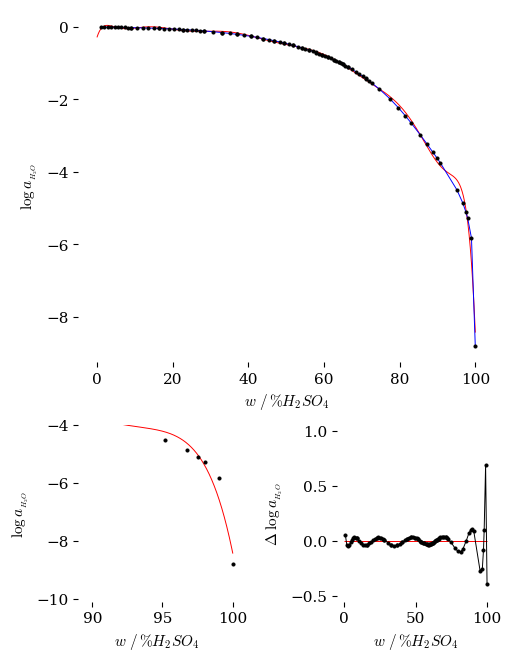

In [265]:
deg = 12

###################################################
### Create figure for plot with insets
###################################################

gs_kw = dict(width_ratios=[1, 1], height_ratios=[2, 1])
fig, axd = plt.subplot_mosaic([['top', 'top'],
                               ['left', 'right']],
                              gridspec_kw=gs_kw, figsize=(5, 6.5),
                              layout="constrained")

style = "tufte.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

###################################################
### Get a Perry data
###################################################

Data_File_Name = "aH2O_data.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

###################################################
### Fit a Polynomial Model to the training data
###################################################

### Convert Molal to PercentWt
### PercentWt = (molality * molwtH2SO4) / (molality * molwtH2SO4 + 1000) * 100
df["PercentWt_Calc"] = (df["m"] * molwtH2SO4) / (df["m"] * molwtH2SO4 + 1000) * 100 


x = df["PercentWt_Calc"]
y = np.log10(df["aH2O"])

# set weights for polynomial fit

weights = [1]*len(x)                         # create list of ones same length as x
#weights[-10:] = [10]*10                     # relace last 10 entries in list with 10
weights[-16:] = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]       # replace last 10 entries in list
#weights[0:10] = [10]*10                     # relace first 10 entries in list with 10
#weights[0:10] = [10,9,8,7,6,5,4,3,2,1]       # replace first 10 entries in list
#print(weights)
#weights = 1/y                               # weight by 1/y to emphasize low values
weights = None                               # erase weights to do unweighted fit

print("weights")
print(weights)
print()

# fit polynomial with weights
p = np.polyfit(x, y, deg, rcond=None, full=False, w=weights, cov=False)

x1 = np.linspace(0,100,5000)                  # x values for polynomial line
y1 = np.polyval(p, x1)


###################################################
###################################################
###################################################
###################################################


###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$\log{a_{_{H_2O}}}$" 


###################################################
### Polynomial Fit Plot
###################################################

# Set up axes for main plot
axd["top"].set(ylabel=y_label, xlabel=x_label,
        xlim=[-5,105],
#        ylim=[-0.05,1]
        )
# Data points for kobs vs Acidity

axd["top"].scatter(x, y, 
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 2)
axd["top"].plot(x1, y1,  
          color = "red", linewidth=0.7, 
          zorder = 1)
axd["top"].plot(x, y,  
          color = "blue", linewidth=0.7, 
          zorder = 1)



###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$\log{a_{_{H_2O}}}$" 


###################################################
### Plot results of polynomial fit - inset
###################################################


# Set up axes for main plot
#axd["left"].set(ylabel=y_label, xlabel=x_label,
#        xlim=[69.5,101],
#        ylim=[-0.03,0.1]
#        )
#axd["left"].set(ylabel=y_label, xlabel=x_label,
#        xlim=[84.5,100.2],
#        ylim=[-0.00005,0.0005],
#        xticks = [85,90,95,100]
#        )
axd["left"].set(ylabel=y_label, xlabel=x_label,
        xlim=[89,100.2],
        ylim=[-10.1,-4]
        )

axd["left"].scatter(x, y, 
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 5)
axd["left"].plot(x1, y1,  
          color = "red", linewidth=0.7, 
          zorder = 1)


###################################################
###################################################
###################################################
###################################################




###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$\Delta\;\log{a_{_{H_2O}}}$" 


###################################################
### RATE vs ACIDITY Plot
###################################################

# Set up axes for main plot
axd["right"].set(ylabel=y_label, xlabel=x_label,
        xlim=[-5,105],
        ylim=[-0.55,1.05],
        yticks = [-0.5,0,0.5,1]       
        )
# Data points for kobs vs Acidit
###################################################
### calculate difference
###################################################
# x_diff = validate_df["%H2SO4"]
# y_diff = validate_df["25C"] - np.polyval(p, validate_df["%H2SO4"])

x_diff = x
y_diff = (y - np.polyval(p, x_diff))
print(y_diff)
axd["right"].scatter(x_diff, y_diff, 
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 5)

axd["right"].plot(x_diff, y_diff,  
          color = "black", linewidth=0.7, 
          zorder = 1)
axd["right"].hlines(0, 0,100, color="red", linewidth=0.7, zorder = 0)   # horizontal line at y=0

#print(x_oca)
plt.savefig("plots/plot_D3.pdf")
plt.show()

## Reexamination of Interpolation by smooth spline

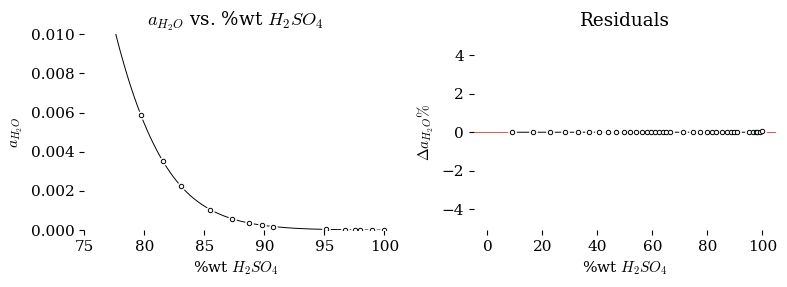

In [266]:
def MakeInterpolationFunctionForH2OActivityinH2SO4byPercentWt():


    Data_File_Name = "01_Giauque_Table9_activityH2OinH2SO4.csv"

    molwtH2SO4 = 98.08; molwtH20 = 18.0; densityH2SO4 = 1.83; densityH2O = 1.000
    
    Filename = github_location + Data_File_Name
    
    df1 = pd.read_csv(Filename, 
                     delimiter = ",", 
                     skipinitialspace=True, 
                     comment = "#") 
    
    molal = df1["conc H2SO4 / m"]
    mass_add_to_1_kg_water = molal * molwtH2SO4
    total_mass_solution = mass_add_to_1_kg_water + 1000
    percent_H2SO4 = mass_add_to_1_kg_water / total_mass_solution * 100
    
    df1["%H2SO4"] = percent_H2SO4
    df1["mole fraction"] = molal / (molal + 1000/molwtH20)

    x = df1["%H2SO4"]
    y = df1["aH2O"]
    
    interpolation = make_smoothing_spline(x, y,      ### The x and y data
                                          w=None,    ### A list of weights for each point (default = None)
                                          lam=0)  ### A factor for the degree of smoothing. Change this to change the smoothness.
    
    return(interpolation)

##############################################################
### Import the data and perform calculations
##############################################################

Filename = github_location + aH2O_Data_File_Name

dfHR = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
#                 index_col="Substituent", 
                 comment = "#") 
 
# ###################################################
### Get the data
###################################################

x = dfHR["%H2SO4"]
y = dfHR["aH2O"]

###################################################
### Use Interpolator for %H2SO4 to H0
###################################################

interpoltor = MakeInterpolationFunctionForH2OActivityinH2SO4byPercentWt()


x_smooth = np.linspace(np.min(x), np.max(x), 1000)
y_smooth = interpoltor(x_smooth)



###################################################
### Set up labels for plots
###################################################

x_label = r"%wt ${H_2SO_4}$"
y_label = r"$a_{H_2O}$"

Title0 = "$a_{H_2O}$ vs. %wt $H_2SO_4$"

Title1 = "Residuals"
y_label_residuals = r"$\Delta a_{H_2O} \%$"

###################################################
### Create figure for plot
###################################################

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)


###################################################
### Make the first plot (plot 0)
###################################################


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[8,3])  

ax[0].set(
          title = Title0,       
          ylabel=y_label, 
          xlabel=x_label,                
          xlim=[75,100.2],                  
          ylim=[-3e-6,1e-2]
       )
#ax[0].set(
#          title = Title0,       
#          ylabel=y_label, 
#          xlabel=x_label,                
#          xlim=[-0.2,100.2],                  
##          ylim=[-1e-6,1e-5]
#       )

ax[0].margins(x=.07, y=.07, tight=True)

ax[0].scatter(x, y, 
             marker = "o", 
             s = 30, 
             color = "white", 
             linewidths=0.7, 
             zorder = 2)
ax[0].scatter(x, y, 
             marker = "o", 
             s = 10, 
             color = "white", 
             edgecolors = "black", 
             linewidths=0.7, 
             zorder = 2)


ax[0].plot(x_smooth, y_smooth, "-", color = "black", linewidth=0.7, zorder = 1)


###################################################
### Make the second plot (plot 1)
###################################################

ax[1].set(
          title = Title1,       
          ylabel=y_label_residuals, 
          xlabel=x_label,                
          xlim=[-5,105],                  
          ylim=[-5.1,5.1]
       )
ax[1].margins(x=.07, y=.07, tight=True)

span = np.max(y) - np.min(y)
diff = y - (interpoltor(x))
percent_diff = diff / y *100


ax[1].scatter(x, percent_diff, 
              marker = "o", 
              s = 30, 
              color = "white", 
              linewidths=0.7, 
              zorder = 2)
ax[1].scatter(x, percent_diff, 
              marker = "o", 
              s = 10, 
              color = "white", 
              edgecolors = "black", 
              linewidths=0.7, 
              zorder = 2)

ax[1].plot(x, percent_diff, "-", color = "white", linewidth=3, zorder = 1)
ax[1].plot(x, percent_diff, "-", color = "black", linewidth=0.7, zorder = 1)
ax[1].hlines(0, -5, 105, color = "red", linewidth=0.5, zorder = 0)

plt.savefig("aH2O_interp.pdf")
plt.show()

0    -0.002149
1     0.002928
2     0.002551
3     0.000178
4    -0.001889
        ...   
75    0.022835
76   -0.314449
77    0.109564
78    0.439414
79   -1.169443
Name: aH2O, Length: 80, dtype: float64


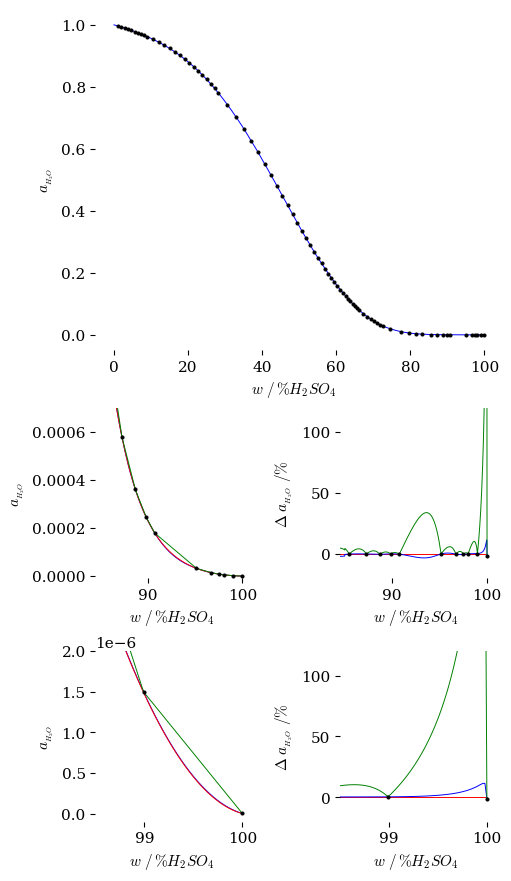

In [267]:
import scipy.interpolate


###################################################
### Create figure for plot with insets
###################################################

gs_kw = dict(width_ratios=[1, 1], height_ratios=[2, 1, 1])
fig, axd = plt.subplot_mosaic([['top', 'top'],
                               ['left', 'right'],
                               ['botleft', 'botright']],
                              gridspec_kw=gs_kw, figsize=(5, 8.7),
                              layout="constrained")

style = "tufte.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

###################################################
### Get a Perry data
###################################################

Data_File_Name = "aH2O_data_no_duplicates.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

###################################################
### Fit a Polynomial Model to the training data
###################################################

### Convert Molal to PercentWt
### PercentWt = (molality * molwtH2SO4) / (molality * molwtH2SO4 + 1000) * 100
df["PercentWt_Calc"] = (df["m"] * molwtH2SO4) / (df["m"] * molwtH2SO4 + 1000) * 100 


x = df["PercentWt_Calc"]
y = df["aH2O"]

interpolation = scipy.interpolate.make_interp_spline(x, y)

#interpolation = scipy.interpolate.Akima1DInterpolator(x, y, method = "akima")        
 
#interpolation = scipy.interpolate.make_smoothing_spline(x, y,   # The x and y data
#                                w=None,       # A list of weights for each point (default = None)
#                                lam=0.        # A factor for the degree of smoothing. Change this to change the smoothness.
#                                )        

x1 = np.linspace(0,100,5000)                  # x values for polynomial line
y1piece = v_piecewise_poly(x1)


y1interp = interpolation(x1)
ydiff_piece = (y1interp - y1piece)/y1piece*100

y1connectdots = np.interp(x1, x, y)
ydiff_connectdots = (y1connectdots - y1piece)/y1piece*100 

###################################################
###################################################
###################################################
###################################################


###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$a_{_{H_2O}}$" 


###################################################
### Polynomial Fit Plot
###################################################

# Set up axes for main plot
axd["top"].set(ylabel=y_label, xlabel=x_label,
        xlim=[-5,102],
#        ylim=[-0.05,1]
        )
# Data points for kobs vs Acidity

axd["top"].scatter(x, y, 
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 2)
axd["top"].plot(x1, y1interp,  
          color = "blue", linewidth=0.7, 
          zorder = 1)



###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$a_{_{H_2O}}$" 


###################################################
### Plot results of polynomial fit - inset
###################################################


axd["left"].set(ylabel=y_label, xlabel=x_label,
        xlim=[84.5,100.5],
        ylim=[-1e-5,7e-4]
        )
axd["left"].scatter(x, y, 
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 5)
axd["left"].plot(x1, y1interp,  
          color = "blue", linewidth=0.7, 
          zorder = 1)
axd["left"].plot(x1, y1piece,  
          color = "red", linewidth=0.7, 
          zorder = 1)
axd["left"].plot(x1, y1connectdots,  
          color = "green", linewidth=0.7, 
          zorder = 1)   

axd["botleft"].set(ylabel=y_label, xlabel=x_label,
        xlim=[98.5,100.05],
        ylim=[-1e-7,2e-6]
        )
axd["botleft"].scatter(x, y, 
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 5)
axd["botleft"].plot(x1, y1interp,  
          color = "blue", linewidth=0.7, 
          zorder = 1)
axd["botleft"].plot(x1, y1piece,  
          color = "red", linewidth=0.7, 
          zorder = 1)
axd["botleft"].plot(x1, y1connectdots,  
          color = "green", linewidth=0.7, 
          zorder = 1)   



###################################################
###################################################
###################################################
###################################################




###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$\Delta\;a_{_{H_2O}}\ /\%$" 


###################################################
### RATE vs ACIDITY Plot
###################################################

# Set up axes for main plot
axd["right"].set(ylabel=y_label, xlabel=x_label,
        xlim=[84.5,100.5],
        ylim=[-20,120],
#        yticks = [-0.5,0,0.5,1]       
        )
# Data points for kobs vs Acidit
###################################################
### calculate difference
###################################################
# x_diff = validate_df["%H2SO4"]
# y_diff = validate_df["25C"] - np.polyval(p, validate_df["%H2SO4"])

x_diff = x
y_diff = (y - interpolation(x_diff))/y*100
y_diff = (y - v_piecewise_poly(x_diff))/y*100

print(y_diff)
axd["right"].scatter(x_diff, y_diff, 
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 5)
#axd["right"].plot(x_diff, y_diff,  
#          color = "black", linewidth=0.7, 
#          zorder = 1)
axd["right"].hlines(0, 0,100, color="red", linewidth=0.7, zorder = 0)   # horizontal line at y=0
axd["right"].plot(x1, ydiff_piece,  
          color = "blue", linewidth=0.7, 
          zorder = 1, label="Piecewise Poly")
axd["right"].plot(x1, ydiff_connectdots,  
          color = "green", linewidth=0.7, 
          zorder = 1, label="Connect Dots")

axd["botright"].set(ylabel=y_label, xlabel=x_label,
        xlim=[98.5,100.05],
        ylim=[-20,120]
        )
axd["botright"].scatter(x_diff, y_diff, 
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 5)
#axd["botright"].plot(x_diff, y_diff,  
#          color = "black", linewidth=0.7, 
#          zorder = 1)
axd["botright"].hlines(0, 0,100, color="red", linewidth=0.7, zorder = 0)   # horizontal line at y=0
axd["botright"].plot(x1, ydiff_piece,  
          color = "blue", linewidth=0.7, 
          zorder = 1, label="Piecewise Poly")
axd["botright"].plot(x1, ydiff_connectdots,  
          color = "green", linewidth=0.7, 
          zorder = 1, label="Connect Dots")


#print(x_oca)
plt.savefig("plots/plot_D4.pdf")
plt.show()

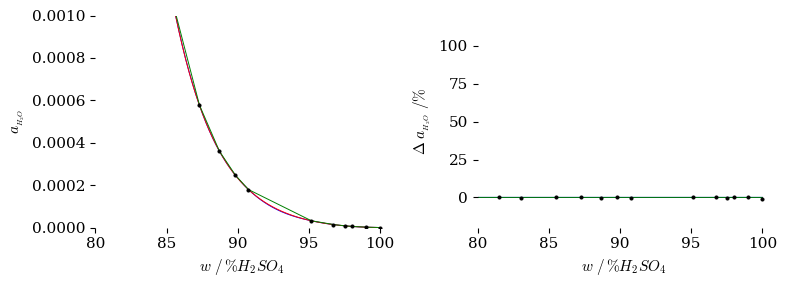

Points is diff between my piecewise fit and given data
Blue is diff between my piecewise fit and spline
Green is diff between my piecewise fit and connect-the-dots


In [268]:
import scipy.interpolate


if True:
        xlim1=[0,20]
        ylim1 = [.9,1]
        ylim2=[-3e-2,1e-2]
if True:
        xlim1=[40,60]
        ylim1 = [.1,0.6]
        ylim2=[-2e-1,2e-1]
if True:
        xlim1=[60,80]
        ylim1 = [-0.02,0.15]
        ylim2=[-1e-0,4e-0]
if True:
        xlim1=[80.0,100.5]
        ylim1 = [-1e-6,1e-3]
        ylim2=[-20,120]

###################################################
### Create figure for plot with insets
###################################################

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[8,3])  

style = "tufte.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

###################################################
### Get a Perry data
###################################################

Data_File_Name = "aH2O_data_no_duplicates.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

###################################################
### Fit a Polynomial Model to the training data
###################################################

### Convert Molal to PercentWt
### PercentWt = (molality * molwtH2SO4) / (molality * molwtH2SO4 + 1000) * 100
df["PercentWt_Calc"] = (df["m"] * molwtH2SO4) / (df["m"] * molwtH2SO4 + 1000) * 100 


x = df["PercentWt_Calc"]
y = df["aH2O"]

interpolation = scipy.interpolate.make_interp_spline(x, y)

#interpolation = scipy.interpolate.Akima1DInterpolator(x, y, method = "akima")        
 
#interpolation = scipy.interpolate.make_smoothing_spline(x, y,   # The x and y data
#                                w=None,       # A list of weights for each point (default = None)
#                                lam=0.        # A factor for the degree of smoothing. Change this to change the smoothness.
#                                )        

x1 = np.linspace(1,100.,5000)                  # x values for polynomial line
y1piece = v_piecewise_poly(x1)


y1interp = interpolation(x1)
ydiff_piece = (y1interp - y1piece)/y1*100

y1connectdots = np.interp(x1, x, y)
ydiff_connectdots = (y1connectdots - y1piece)/y1*100 

###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$a_{_{H_2O}}$" 


###################################################
### Polynomial Fit Plot
###################################################

# Set up axes for main plot
ax[0].set(ylabel=y_label, xlabel=x_label,
        xlim=xlim1,
        ylim=ylim1
        )
ax[0].scatter(x, y, 
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 2)
ax[0].plot(x1, y1interp,  
          color = "blue", linewidth=0.7, 
          zorder = 1)
ax[0].plot(x1, y1piece,  
          color = "red", linewidth=0.7, 
          zorder = 1)
ax[0].plot(x1, y1connectdots,  
          color = "green", linewidth=0.7, 
          zorder = 1)   


###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$\Delta\;a_{_{H_2O}}\ /\%$" 

ax[1].set(ylabel=y_label, xlabel=x_label,
        xlim=xlim1,
        ylim=ylim2,
#        yticks = [-0.5,0,0.5,1]       
        )

x_diff = x
#y_diff = (y - interpolation(x_diff))/y*100
y_diff = (y - v_piecewise_poly(x_diff))/y*100


ax[1].scatter(x_diff, y_diff, 
          marker = "o", s = 5, 
          color = "black", edgecolors = "black", linewidths=0.7, 
          zorder = 5)
#ax[1].plot(x_diff, y_diff,  
#          color = "black", linewidth=0.7, 
#          zorder = 1)
ax[1].hlines(0, 0,100, color="red", linewidth=0.7, zorder = 0)   # horizontal line at y=0
ax[1].plot(x1, ydiff_piece,  
          color = "blue", linewidth=0.7, 
          zorder = 1, label="Piecewise Poly")
ax[1].plot(x1, ydiff_connectdots,  
          color = "green", linewidth=0.7, 
          zorder = 1, label="Connect Dots")


#print(x_oca)
plt.savefig("plots/plot_E1.pdf")
plt.show()

print("Points is diff between my piecewise fit and given data")
print("Blue is diff between my piecewise fit and spline")
print("Green is diff between my piecewise fit and connect-the-dots")

## Models for $H_0$

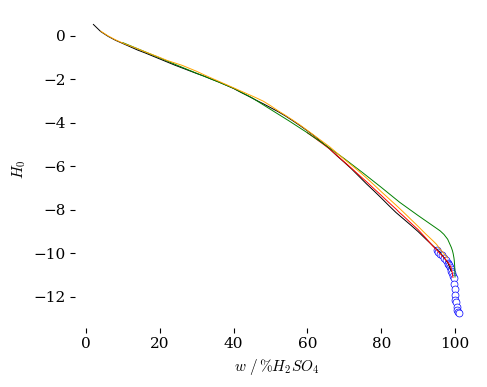

In [269]:
###################################################
### Create figure for plot
###################################################

style = "tufte.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  
#ax2 = ax.twinx()

###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$H_0$" 


# Set up axes for main plot
ax.set(ylabel=y_label, xlabel=x_label,
#        xlim=[-5,105],
#        ylim=[0.95,2.05]
        )
# Data points for kobs vs Acidity

###################################################
### Get and plot Gillespie data
###################################################

Data_File_Name = "02_H0_H2SO4_Gillespie_1971.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

x = df["%H2SO4"]
y = df["H0"]

ax.plot(x, y,  
          color = "blue", linewidth=0.7, 
          marker = "o", ms = 5, mec = "blue", mfc = "white", mew = 0.5,
          zorder = 1)
#ax.scatter(x, y, 
#          marker = "o", s = 5, 
#          color = "black", edgecolors = "black", linewidths=0.7, 
#          zorder = 3)


###################################################
### Get and plot Johnston data
###################################################

Data_File_Name = "02_H0_H2SO4_Johnston_1969.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

x = df["%H2SO4"]
y = df["H0"]

ax.plot(x, y,  
          color = "black", linewidth=0.7, 
          zorder = 1)

#ax.scatter(x, y, 
#          marker = "o", s = 40, 
#          color = "white", edgecolors = "green", linewidths=0.7, 
#          zorder = 2)
###################################################
### Get and plot Jorgenson data
###################################################

Data_File_Name = "02_H0_H2SO4_Jorgenson_1963.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

x = df["%H2SO4"]
y = df["H0"]

#ax.scatter(x, y, 
#          marker = "o", s = 80, 
#          color = "white", edgecolors = "red", linewidths=0.7, 
#          zorder = 1)

ax.plot(x, y,  
          color = "red", linewidth=0.7, 
          zorder = 1)

###################################################
### Get and plot Paul data
###################################################

Data_File_Name = "02_H0_H2SO4_Paul_1957B.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

x = df["%H2SO4"]
y = df["H0"]

#ax.scatter(x, y, 
#          marker = "o", s = 80, 
#          color = "white", edgecolors = "red", linewidths=0.7, 
#          zorder = 1)

ax.plot(x, y,  
          color = "green", linewidth=0.7, 
          zorder = 1)

###################################################
### Get and plot Tickle data
###################################################

Data_File_Name = "02_H0_H2SO4_Tickle_1970.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

x = df["%H2SO4"]
y = df["H0"]

#ax.scatter(x, y, 
#          marker = "o", s = 80, 
#          color = "white", edgecolors = "red", linewidths=0.7, 
#          zorder = 1)

ax.plot(x, y,  
          color = "orange", linewidth=0.7, 
          zorder = 1)


plt.savefig("plots/plot_F1.pdf")
plt.show()



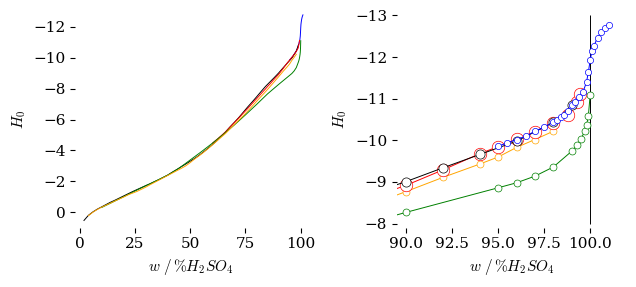

In [270]:
###################################################
### Create figure for plot
###################################################

style = "tufte.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

#ax2 = ax.twinx()

###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$H_0$" 

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[6.5,3])  

ax[0].set(
#          title = Title0,       
          ylabel=y_label, 
          xlabel=x_label,                
          xlim=[-2,102],                  
          ylim=[1, -13]
       )
ax[1].set(
#          title = Title0,       
          ylabel=y_label, 
          xlabel=x_label,                
          xlim=[89.5,102],                  
          ylim=[-7.9, -13.1]
       )

###################################################
### Get and plot Gillespie data
###################################################

Data_File_Name = "02_H0_H2SO4_Gillespie_1971.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

x = df["%H2SO4"]
y = df["H0"]

ax[0].plot(x, y,  
          color = "blue", linewidth=0.7, 
#          marker = "o", ms = 5, mec = "blue", mfc = "white", mew = 0.5,
          zorder = 1)
ax[1].plot(x, y,  
          color = "blue", linewidth=0.7, 
          marker = "o", ms = 4.5, mec = "blue", mfc = "white", mew = 0.5,
          zorder = 5)
#ax.scatter(x, y, 
#          marker = "o", s = 5, 
#          color = "black", edgecolors = "black", linewidths=0.7, 
#          zorder = 3)


###################################################
### Get and plot Johnston data
###################################################

Data_File_Name = "02_H0_H2SO4_Johnston_1969.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

x = df["%H2SO4"]
y = df["H0"]

ax[0].plot(x, y,  
          color = "black", linewidth=0.7, 
          zorder = 1)
ax[1].plot(x, y,  
          color = "black", linewidth=0.7, 
          marker = "o", ms = 6.6, mec = "black", mfc = "white", mew = 0.5,
          zorder = 4)

#ax.scatter(x, y, 
#          marker = "o", s = 40, 
#          color = "white", edgecolors = "green", linewidths=0.7, 
#          zorder = 2)
###################################################
### Get and plot Jorgenson data
###################################################

Data_File_Name = "02_H0_H2SO4_Jorgenson_1963.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

x = df["%H2SO4"]
y = df["H0"]

#ax.scatter(x, y, 
#          marker = "o", s = 80, 
#          color = "white", edgecolors = "red", linewidths=0.7, 
#          zorder = 1)

ax[0].plot(x, y,  
          color = "red", linewidth=0.7, 
          zorder = 1)
ax[1].plot(x, y,  
          color = "red", linewidth=0.7, 
          marker = "o", ms = 9, mec = "red", mfc = "white", mew = 0.5,
          zorder = 3)

###################################################
### Get and plot Paul data
###################################################

Data_File_Name = "02_H0_H2SO4_Paul_1957B.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

x = df["%H2SO4"]
y = df["H0"]

#ax.scatter(x, y, 
#          marker = "o", s = 80, 
#          color = "white", edgecolors = "red", linewidths=0.7, 
#          zorder = 1)

ax[0].plot(x, y,  
          color = "green", linewidth=0.7, 
          zorder = 1)
ax[1].plot(x, y,  
          color = "green", linewidth=0.7, 
          marker = "o", ms = 5, mec = "green", mfc = "white", mew = 0.5,
          zorder = 1)

###################################################
### Get and plot Tickle data
###################################################

Data_File_Name = "02_H0_H2SO4_Tickle_1970.csv"
Filename = github_location + Data_File_Name
df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

x = df["%H2SO4"]
y = df["H0"]

#ax.scatter(x, y, 
#          marker = "o", s = 80, 
#          color = "white", edgecolors = "red", linewidths=0.7, 
#          zorder = 1)

ax[0].plot(x, y,  
          color = "orange", linewidth=0.7, 
          zorder = 1)
ax[1].plot(x, y,  
          color = "orange", linewidth=0.7, 
          marker = "o", ms = 5, mec = "orange", mfc = "white", mew = 0.5,
          zorder = 1)

ax[1].vlines(100,-13,-8, linewidth = 0.7, zorder = 0)
plt.savefig("plots/plot_F1.pdf")
plt.show()



parameters
[-3.052197698987788e-24, 2.012020262234799e-21, -5.857235901512276e-19, 9.865265062228765e-17, -1.054140158277945e-14, 7.303852158563382e-13, -3.124854597988488e-11, 6.186355721718086e-10, 1.1400413355222262e-08, -1.1506796698057053e-06, 3.51879583161204e-05, -0.0005621224640219923, 0.004435460724695928, -0.007020870849298638, -0.18900684247595326, 0.90609122154642]


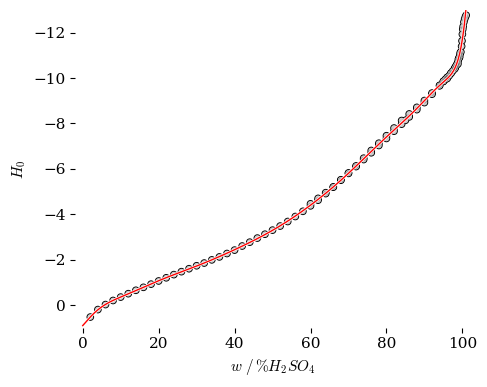

In [271]:

###################################################
### Get  Gillespie data
###################################################

Data_File_Name = "02_H0_H2SO4_Gillespie_1971.csv"
Filename = github_location + Data_File_Name
df_gill = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

###################################################
### Get Johnston data
###################################################

Data_File_Name = "02_H0_H2SO4_Johnston_1969.csv"
Filename = github_location + Data_File_Name
df_johnson = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

###################################################
### Get and plot Jorgenson data
###################################################

Data_File_Name = "02_H0_H2SO4_Jorgenson_1963.csv"
Filename = github_location + Data_File_Name
df_jorg = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

df = pd.concat([df_gill, df_johnson, df_jorg]).sort_values(by="%H2SO4").reset_index(drop=True)

x = df["%H2SO4"]
y = df["H0"]

# set weights for polynomial fit

weights = [1]*len(x)                         # create list of ones same length as x
#weights[-10:] = [10]*10                     # relace last 10 entries in list with 10
weights[-10:] = [1,2,3,4,5,6,7,8,9,10]       # replace last 10 entries in list
#weights[0:10] = [10]*10                     # relace first 10 entries in list with 10
#weights[0:10] = [10,9,8,7,6,5,4,3,2,1]       # replace first 10 entries in list
#print(weights)
weights = None                               # erase weights to do unweighted fit

# fit polynomial with weights
deg = 15
p2 = np.polyfit(x, y, deg, rcond=None, full=False, w=weights, cov=False)

print("parameters")
print(json.dumps(p2.tolist()))

x1 = np.linspace(0,103,500)                  # x values for polynomial line
y1 = np.polyval(p2, x1)
y_diff = y - np.polyval(p2, x)

style = "tufte.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$H_0$" 

ax.set(
#          title = Title0,       
          ylabel=y_label, 
          xlabel=x_label,                
          xlim=[-2,102],                  
          ylim=[1,-13]
       )


ax.scatter(x, y, 
          marker = "o", s = 30, 
          color = "black", edgecolors = "none", linewidths=0, 
          zorder = 3)

ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "white", edgecolors = "none", linewidths=0, 
          zorder = 4)

ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "black", edgecolors = "none", linewidths=0, 
          alpha = 0.2,
          zorder = 5)

ax.plot(x1,y1,zorder=10,linewidth=2,color="white")
ax.plot(x1,y1,zorder=10,linewidth=1,color="red")

plt.savefig("plots/plot_G1.pdf")
plt.show()


parameters
[-3.052197698987788e-24, 2.012020262234799e-21, -5.857235901512276e-19, 9.865265062228765e-17, -1.054140158277945e-14, 7.303852158563382e-13, -3.124854597988488e-11, 6.186355721718086e-10, 1.1400413355222262e-08, -1.1506796698057053e-06, 3.51879583161204e-05, -0.0005621224640219923, 0.004435460724695928, -0.007020870849298638, -0.18900684247595326, 0.90609122154642]


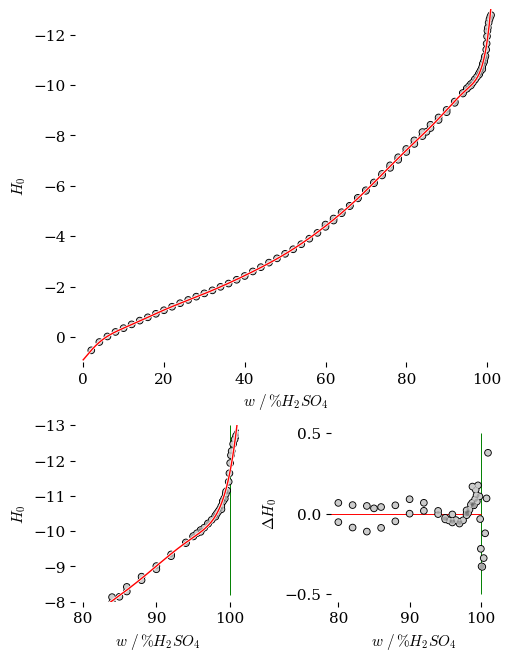

In [272]:
###################################################
### Get  Gillespie data
###################################################

Data_File_Name = "02_H0_H2SO4_Gillespie_1971.csv"
Filename = github_location + Data_File_Name
df_gill = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

###################################################
### Get Johnston data
###################################################

Data_File_Name = "02_H0_H2SO4_Johnston_1969.csv"
Filename = github_location + Data_File_Name
df_johnson = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

###################################################
### Get and plot Jorgenson data
###################################################

Data_File_Name = "02_H0_H2SO4_Jorgenson_1963.csv"
Filename = github_location + Data_File_Name
df_jorg = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

df = pd.concat([df_gill, df_johnson, df_jorg]).sort_values(by="%H2SO4").reset_index(drop=True)

x = df["%H2SO4"]
y = df["H0"]

# set weights for polynomial fit

weights = [1]*len(x)                         # create list of ones same length as x
#weights[-10:] = [10]*10                     # relace last 10 entries in list with 10
weights[-10:] = [1,2,3,4,5,6,7,8,9,10]       # replace last 10 entries in list
#weights[0:10] = [10]*10                     # relace first 10 entries in list with 10
#weights[0:10] = [10,9,8,7,6,5,4,3,2,1]       # replace first 10 entries in list
#print(weights)
weights = None                               # erase weights to do unweighted fit

# fit polynomial with weights
deg = 15
p2 = np.polyfit(x, y, deg, rcond=None, full=False, w=weights, cov=False)

print("parameters")
print(json.dumps(p2.tolist()))

x1 = np.linspace(0,103,500)                  # x values for polynomial line
y1 = np.polyval(p2, x1)
y_diff = y - np.polyval(p2, x)

###################################################
###################################################
###################################################
###################################################

gs_kw = dict(width_ratios=[1, 1], height_ratios=[2, 1])
fig, axd = plt.subplot_mosaic([['top', 'top'],
                               ['left', 'right']],
                              gridspec_kw=gs_kw, figsize=(5, 6.5),
                              layout="constrained")

style = "tufte.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)


###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$H_0$" 

axd["top"].set(
#          title = Title0,       
          ylabel=y_label, 
          xlabel=x_label,                
          xlim=[-2,102],                  
          ylim=[1,-13]
       )



###################################################
### Polynomial Fit Plot
###################################################


axd["top"].scatter(x, y, 
          marker = "o", s = 30, 
          color = "black", edgecolors = "none", linewidths=0, 
          zorder = 3)

axd["top"].scatter(x, y, 
          marker = "o", s = 17, 
          color = "white", edgecolors = "none", linewidths=0, 
          zorder = 4)

axd["top"].scatter(x, y, 
          marker = "o", s = 17, 
          color = "black", edgecolors = "none", linewidths=0, 
          alpha = 0.2,
          zorder = 5)

axd["top"].plot(x1,y1,zorder=10,linewidth=2,color="white")
axd["top"].plot(x1,y1,zorder=10,linewidth=1,color="red")


#axd["top"].scatter(x, y, 
#          marker = "o", s = 5, 
#          color = "black", edgecolors = "black", linewidths=0.7, 
#          zorder = 5)
#
#axd["top"].plot(x, y,  
#          color = "red", linewidth=0.7, 
#          zorder = 1)


###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$H_0$" 

###################################################
### Plot results of polynomial fit - inset
###################################################


axd["left"].set(ylabel=y_label, xlabel=x_label,
        xlim=[79,101.2],
        ylim=[-8,-13]
        )

axd["left"].scatter(x, y, 
          marker = "o", s = 30, 
          color = "black", edgecolors = "none", linewidths=0, 
          zorder = 3)

axd["left"].scatter(x, y, 
          marker = "o", s = 17, 
          color = "white", edgecolors = "none", linewidths=0, 
          zorder = 4)

axd["left"].scatter(x, y, 
          marker = "o", s = 17, 
          color = "black", edgecolors = "none", linewidths=0, 
          alpha = 0.2,
          zorder = 5)
axd["left"].plot(x1,y1,zorder=10,linewidth=2,color="white")
axd["left"].plot(x1,y1,zorder=10,linewidth=1,color="red")

axd["left"].vlines(100, -8.2, -13, zorder=0, linewidth=0.7, color="green")

#axd["left"].scatter(x, y, 
#          marker = "o", s = 5, 
#          color = "black", edgecolors = "black", linewidths=0.7, 
#          zorder = 5)
#axd["left"].plot(x1, y1,  
#          color = "red", linewidth=0.7, 
#          zorder = 1)


###################################################
###################################################
###################################################
###################################################




###################################################
### Set up labels
###################################################

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$\Delta H_0$" 


###################################################
### RATE vs ACIDITY Plot
###################################################

# Set up axes for main plot
axd["right"].set(ylabel=y_label, xlabel=x_label,
        xlim=[-2,105],
        ylim=[-0.55,0.55],
        yticks = [-0.5,0,0.5]       
        )
axd["right"].set(ylabel=y_label, xlabel=x_label,
        xlim=[79,102],
        ylim=[-0.55,0.55],
        yticks = [-0.5,0,0.5]       
        )
# Data points for kobs vs Acidit
###################################################
### calculate difference
###################################################
# x_diff = validate_df["%H2SO4"]
# y_diff = validate_df["25C"] - np.polyval(p, validate_df["%H2SO4"])

x_diff = x
y_diff = (y - np.polyval(p2, x_diff))

axd["right"].scatter(x_diff, y_diff, 
          marker = "o", s = 30, 
          color = "black", edgecolors = "none", linewidths=0, 
          zorder = 3)

axd["right"].scatter(x_diff, y_diff, 
          marker = "o", s = 17, 
          color = "white", edgecolors = "none", linewidths=0, 
          zorder = 4)

axd["right"].scatter(x_diff, y_diff,
          marker = "o", s = 17, 
          color = "black", edgecolors = "none", linewidths=0, 
          alpha = 0.2,
          zorder = 5)
axd["right"].vlines(100, -0.5, 0.5, zorder=0, linewidth=0.7, color="green")


#axd["right"].scatter(x_diff, y_diff, 
#          marker = "o", s = 5, 
#          color = "black", edgecolors = "black", linewidths=0.7, 
#          zorder = 5)
#
#axd["right"].plot(x_diff, y_diff,  
#          color = "black", linewidth=0.7, 
#          zorder = 1)
axd["right"].hlines(0, 0,100, color="red", linewidth=0.7, zorder = 0)   # horizontal line at y=0

#print(x_oca)
plt.savefig("plots/plot_G2.pdf")
plt.show()

## A Spline Interpolation USING JOHNSON AND GILLESPIE

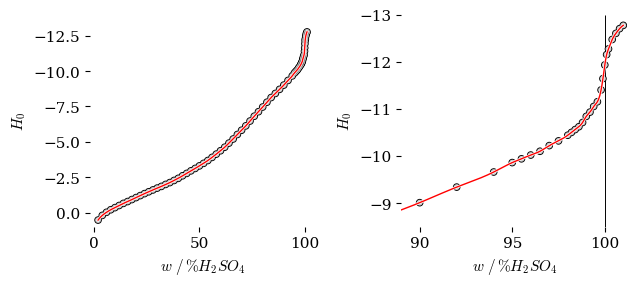

In [273]:

###################################################
### Get  Gillespie data
###################################################

Data_File_Name = "02_H0_H2SO4_Gillespie_1971.csv"
Filename = github_location + Data_File_Name
df_gill = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

###################################################
### Get Johnston data
###################################################

Data_File_Name = "02_H0_H2SO4_Johnston_1969.csv"
Filename = github_location + Data_File_Name
df_johnson = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

###################################################
### Get and plot Jorgenson data
###################################################

Data_File_Name = "02_H0_H2SO4_Jorgenson_1963.csv"
Filename = github_location + Data_File_Name
df_jorg = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 


df_johnson = df_johnson.loc[df_johnson["%H2SO4"] < 94.9]

df = pd.concat([df_gill, df_johnson]).sort_values(by="%H2SO4").reset_index(drop=True)
#df = df.reset_index().groupby("%H2SO4").mean()


x = df["%H2SO4"]
#x = df.index
y = df["H0"]


interpolation = scipy.interpolate.make_interp_spline(x, y)

#interpolation = scipy.interpolate.Akima1DInterpolator(x, y, method = "akima")        
 
#interpolation = scipy.interpolate.make_smoothing_spline(x, y,   # The x and y data
#                                w=None,       # A list of weights for each point (default = None)
#                                lam=0.005        # A factor for the degree of smoothing. Change this to change the smoothness.
#                                )        

x1 = np.linspace(2, 101, 5000)                  # x values for polynomial line
y1interp = interpolation(x1)

style = "tufte.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[6.5,3])  
#ax2 = ax.twinx()

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$H_0$" 

ax[0].set(ylabel = y_label, 
          xlabel = x_label,
          xlim=[-2,105],
          ylim=[1,-14]
        )

ax[0].scatter(x, y, 
          marker = "o", s = 30, 
          color = "black", edgecolors = "none", linewidths=0, 
          zorder = 3)

ax[0].scatter(x, y, 
          marker = "o", s = 17, 
          color = "white", edgecolors = "none", linewidths=0, 
          zorder = 4)

ax[0].scatter(x, y, 
          marker = "o", s = 17, 
          color = "black", edgecolors = "none", linewidths=0, 
          alpha = 0.2,
          zorder = 5)

ax[0].plot(x1,y1interp,zorder=10,linewidth=2,color="white")
ax[0].plot(x1,y1interp,zorder=10,linewidth=1,color="red")

#ax[0].vlines(100, -8.2, -13, linewidth=0.7, color="black", zorder = 0)

##################################

ax[1].set(ylabel=y_label, 
          xlabel=x_label,
          xlim=[89,101.2],
          ylim=[-8.5,-13]
        )

ax[1].scatter(x, y, 
          marker = "o", s = 30, 
          color = "black", edgecolors = "none", linewidths=0, 
          zorder = 3)

ax[1].scatter(x, y, 
          marker = "o", s = 17, 
          color = "white", edgecolors = "none", linewidths=0, 
          zorder = 4)

ax[1].scatter(x, y, 
          marker = "o", s = 17, 
          color = "black", edgecolors = "none", linewidths=0, 
          alpha = 0.2,
          zorder = 5)

ax[1].plot(x1,y1interp,zorder=10,linewidth=2,color="white")
ax[1].plot(x1,y1interp,zorder=10,linewidth=1,color="red")

ax[1].vlines(100, -8.2, -13, linewidth=0.7, color="black", zorder = 0)

##################################
plt.savefig("plots/plot_G3.pdf")
plt.show()
